# Do Batch Processing

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import sys
import localSettings as ls
import math
print(ls.main_path)
import load_data_run123
import plotter_alex
import importlib
importlib.reload(plotter_alex)
import uproot
import matplotlib.pylab as pylab
import numpy as np
import math
from sklearn.model_selection import train_test_split
import pickle
import xgboost as xgb
import nue_booster 
importlib.reload(nue_booster)
import awkward

/home/alex/NuMI/PELEE/


## BNB Sample Histograms - Nue Nue

In [2]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#cut samples
#NUE  = '/pre_samp/prodgenie_numi_nue_overlay_mcc9_v08_00_00_48_CV_reco2_run1_reco2'+ls.APPEND #newTune
#full sample
NUE  = '/neutrinoselection_filt_run1_overlay_intrinsic'+ls.APPEND #newTune

#actually fetch datasets
nue_nue  = uproot.open(ls.ntuple_path+NUE+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_nue]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance", "shr_theta", "shr_phi",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'npion', 'trk_energy']


# These are examples of variables present in MC samples only
nue_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#"elec_vx", "elec_vy", "elec_vz", "elec_px","elec_py","elec_pz", , "elec_e"

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_nue  = nue_nue.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)

['slnhits', 'shr_tkfit_nhits_U', 'run', 'shr_phi', 'nslice', 'shr_tkfit_nhits_Y', 'n_showers_contained', 'hits_ratio', 'shr_energy', 'shr_tkfit_dedx_Y', 'shrsubclusters1', 'shr_tkfit_dedx_V', 'trk_score_v', 'nproton', 'tksh_distance', 'shrmoliereavg', 'trk_energy_tot', 'n_tracks', 'shr_tkfit_npoints', 'shr_distance', 'reco_nu_vtx_sce_y', 'n_showers', 'shr_energy_tot_cali', 'nu_pdg', 'shr_energy_cali', 'reco_nu_vtx_sce_z', 'shrsubclusters0', 'trkshrhitdist2', 'sub', 'selected', 'n_tracks_contained', 'slnunhits', 'shr_score', 'tksh_angle', 'contained_fraction', 'ccnc', 'npion', 'evt', 'topological_score', 'reco_nu_vtx_sce_x', 'CosmicIPAll3D', 'category', 'shr_theta', 'shr_tkfit_nhits_V', 'shrsubclusters2', 'flash_time', 'trk_energy', 'shr_tkfit_dedx_U']


In [3]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_nue]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    #print(df['mc_pdg'])

entry
0         [-11, 2112, 2212, 2112]
1                      [11, 2212]
2                [11, 2212, 2112]
3                      [11, 2212]
4                      [11, 2212]
                   ...           
127546                 [11, 2212]
127547      [11, 2212, 111, 2212]
127548       [11, 2212, 211, 111]
127549                [-11, 2112]
127550                 [11, 2212]
Name: mc_pdg, Length: 127551, dtype: object


In [24]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_nue]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    """
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.
    """

In [25]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [26]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [28]:
#These two are the same

#print(df["elec_vx"])
#print(df["true_nu_vtx_x"])

entry
0         242.379379
1         131.187790
2          71.178825
3         148.895935
4         130.629791
             ...    
127546     89.494492
127547     89.124741
127548     40.066914
127549    203.134888
127550     17.868587
Name: elec_vx, Length: 127551, dtype: float32
entry
0         242.379379
1         131.187790
2          71.178825
3         148.895935
4         130.629791
             ...    
127546     89.494492
127547     89.124741
127548     40.066914
127549    203.134888
127550     17.868587
Name: true_nu_vtx_x, Length: 127551, dtype: float32


In [7]:
for i,df in enumerate(df_v):
    df["elec_px_asmuon"] = np.nan
    df["elec_py_asmuon"] = np.nan
    df["elec_pz_asmuon"] = np.nan
    for j in range(len(df["mc_pdg"])):
        pdg_vector = df["mc_pdg"].iloc[j][0]
        px_vector = df["mc_px"].iloc[j]
        py_vector = df["mc_py"].iloc[j]
        pz_vector = df["mc_pz"].iloc[j]
        result = np.where(pdg_vector==11)[0]
        if np.size(result):
            df.loc[j, "elec_px_asmuon"] = px_vector[result][0]
            df.loc[j, "elec_py_asmuon"] = py_vector[result][0]
            df.loc[j, "elec_pz_asmuon"] = pz_vector[result][0]
            
    print(df["elec_px_asmuon"])

entry
0              NaN
1         1.504711
2        -0.197600
3         0.142221
4         0.128535
            ...   
127546    0.195821
127547    2.786030
127548    1.216194
127549         NaN
127550    0.975678
Name: elec_px_asmuon, Length: 127551, dtype: float64


In [8]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_nue]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  20.793810844421387


In [9]:
#Call same as that below

#for i,df in enumerate(df_v):
#    df['targetP']     = np.sqrt(df['elec_px']*df['elec_px'] + df['elec_py']*df['elec_py'] + df['elec_pz']*df['elec_pz'])
#    df['targetPt']    = np.sqrt(df['elec_px']*df['elec_px'] + df['elec_py']*df['elec_py'])
#    df['targetTheta'] = np.arccos(df['elec_pz']/df['targetP'] )
#    df['targetPhi']   = np.arctan2(df['elec_py'],df['elec_px'])
#    df['nu_Angle_Numi_Elec'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta'],x['targetPhi']) , axis=1)
#    df['cosNu_Angle_Numi_Elec'] = np.cos(df['nu_Angle_Numi_Elec'])
#   # df['shr_Angle_Numi_target'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['shr_theta'],x['shr_phi']) , axis=1)
#   # df['cosShr_Angle_Numi_target'] = np.cos(df['shr_Angle_Numi_target'])

In [10]:
#Electron Angle

for i,df in enumerate(df_v):
    df['targetP_asmuon']     = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'] + df['elec_pz_asmuon']*df['elec_pz_asmuon'])
    df['targetPt_asmuon']    = np.sqrt(df['elec_px_asmuon']*df['elec_px_asmuon'] + df['elec_py_asmuon']*df['elec_py_asmuon'])
    df['targetTheta_asmuon'] = np.arccos(df['elec_pz_asmuon']/df['targetP_asmuon'] )
    df['targetPhi_asmuon']   = np.arctan2(df['elec_py_asmuon'],df['elec_px_asmuon'])
    df['nu_Angle_Numi_Elec_asmuon'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta_asmuon'],x['targetPhi_asmuon']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon'] = np.cos(df['nu_Angle_Numi_Elec_asmuon'])

In [ ]:
#Neutrino Angle

for i,df in enumerate(df_v):
    df['targetP_asmuon_nu']     = np.sqrt(df['true_nu_px']*df['true_nu_px'] + df['true_nu_py']*df['true_nu_py'] + df['true_nu_pz']*df['true_nu_pz'])
    df['targetPt_asmuon_nu']    = np.sqrt(df['true_nu_px']*df['true_nu_px'] + df['true_nu_py']*df['true_nu_py'])
    df['targetTheta_asmuon_nu'] = np.arccos(df['true_nu_pz']/df['targetP_asmuon_nu'] )
    df['targetPhi_asmuon_nu']   = np.arctan2(df['true_nu_py'],df['true_nu_px'])
    df['nu_Angle_Numi_Elec_asmuon_nu'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta_asmuon_nu'],x['targetPhi_asmuon_nu']) , axis=1)
    df['cosNu_Angle_Numi_Elec_asmuon_nu'] = np.cos(df['nu_Angle_Numi_Elec_asmuon_nu'])

In [ ]:
df['cosNu_Lepton_Angle'] = df['cosNu_Angle_Numi_Elec_asmuon'] - df['cosNu_Angle_Numi_Elec_asmuon_nu']

In [13]:
#for i,df in enumerate(df_v):
#    print(df['elec_px'])
#    print(df['elec_px_asmuon'])
#    print(df['cosNu_Angle_Numi_Elec'])
#    print(df['cosNu_Angle_Numi_Elec_asmuon'])

entry
0        -0.383097
1         0.714287
2        -0.572533
3         0.150274
4         0.214978
            ...   
127546    0.212007
127547    0.545832
127548    0.341724
127549    0.037071
127550    0.532764
Name: elec_px, Length: 127551, dtype: float32
entry
0              NaN
1         1.504711
2        -0.197600
3         0.142221
4         0.128535
            ...   
127546    0.195821
127547    2.786030
127548    1.216194
127549         NaN
127550    0.975678
Name: elec_px_asmuon, Length: 127551, dtype: float64
entry
0         0.218543
1         0.947911
2        -0.748580
3         0.919988
4         0.735780
            ...   
127546    0.917622
127547    0.994450
127548    0.979082
127549    0.838999
127550    0.981234
Name: cosNu_Angle_Numi_Elec, Length: 127551, dtype: float64
entry
0              NaN
1         0.947911
2        -0.748580
3         0.919988
4         0.735780
            ...   
127546    0.917622
127547    0.994450
127548    0.979082
127549         NaN


In [9]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [10]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [11]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_nue]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])


In [12]:
# add back the cosmic category, for background only
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    

In [13]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_nue]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [14]:
#Define signal catagories

nue_nue["is_signal"] = nue_nue["category"] == 11

In [15]:
# Some quick clean up since some strange events get in there
nue_nue   = nue_nue.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_nue]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [16]:
df_v = [nue_nue]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

In [17]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [18]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [19]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_nue]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(127551, 122)


In [20]:
datasets_bdt = nue_nue

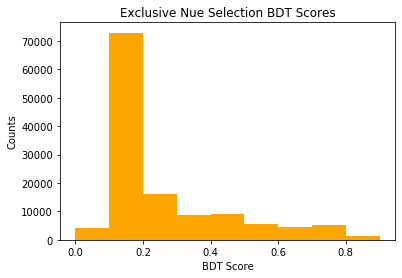

In [21]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [22]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

In [23]:
truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
truthsel_nue  += " and category == 11"

truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
truthsel_numu  += " and category == 2"

n_events here =  127551

3.188775
3
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_nue
[]

SUMS
[]
[]

Wanted List:
[]


current n_tot  [ 9.58356437 47.48897896 34.97857836 13.57236432  5.03287171  2.77814385
  1.47331751  0.75697718  0.3909056   0.25045624]

Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sampl

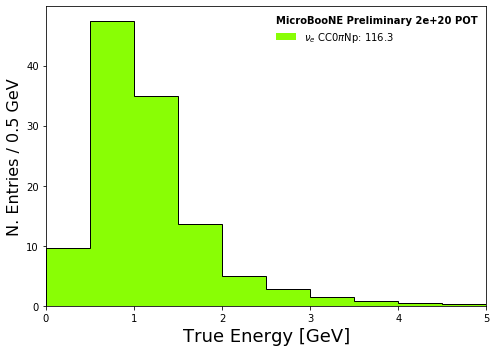

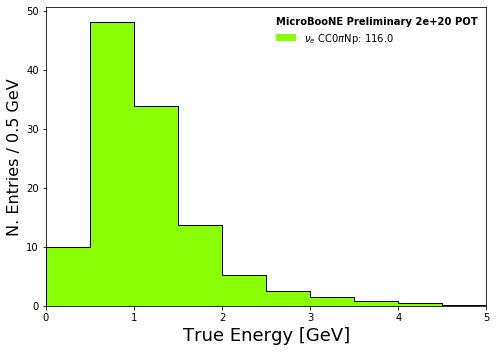

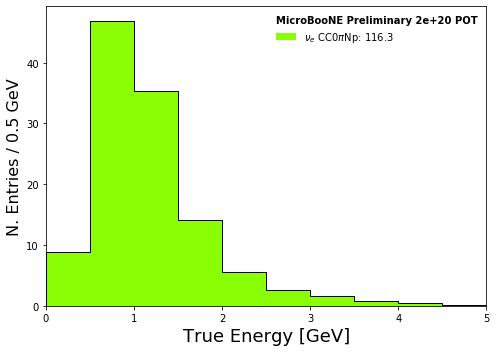

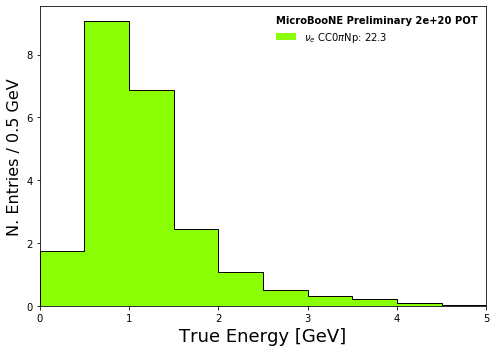

In [50]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "nue_nue": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    nueratio  = pot/2.37838e+22 

    # NUE
    weights = { #full sample mc = 0.38
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #BDT


    #Now check on a variable

    #Remember to change the plotter keys between truth and mc
    
    VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Lepton_Angle',10,(-1.0, 1.0),"cos(Angle Diff)"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]

    #ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
    #ax1.set_yscale("log")
    #fig.tight_layout()
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)
    

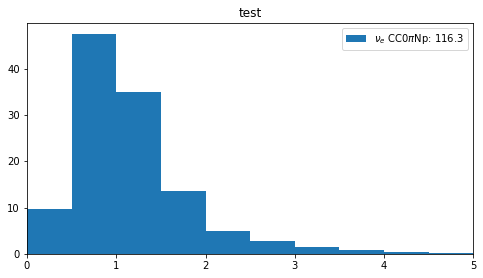

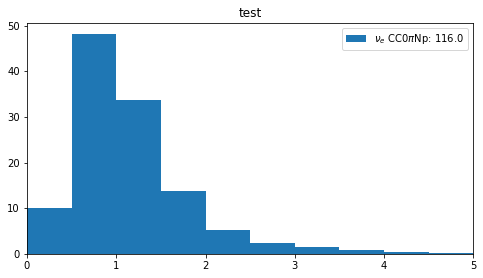

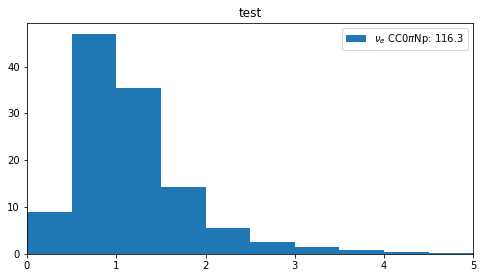

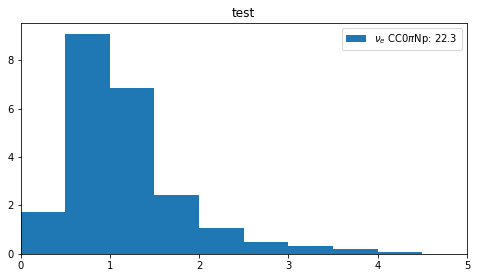

In [51]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])    #TrueE
    #nue_ax1.set_xlim([-1, 1])    #AngleElec

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()

In [52]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

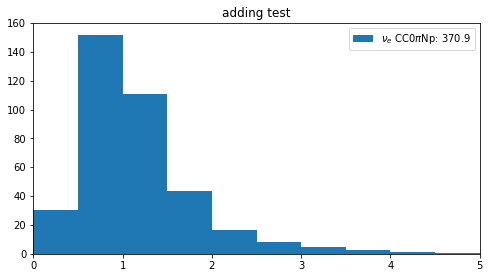

In [53]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$", # look for this
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])

#TrueE
nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 200])
nue_ax1.set_ylim([0, 160])

#AngleElec
#nue_ax1.set_xlim([-1, 1])
#nue_ax1.set_ylim([0, 160])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [54]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 1

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [55]:
#varss_tot[0].to_csv('nue_nue_varstot.csv')
#weights_tot[0].to_csv('nue_nue_varstot.csv')

#print(varss_tot[0])


vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

#presamp
#vars_tot_df.to_csv('nue_nue_varstot.csv')
#weights_tot_df.to_csv('nue_nue_weightstot.csv')

#full trueE
vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_trueE.csv')
weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_trueE.csv')
#angleElec
#vars_tot_df.to_csv('nue_nue_varstot_full_catsel_nopions_angleElec.csv')
#weights_tot_df.to_csv('nue_nue_weightstot_full_catsel_nopions_angleElec.csv')

### Stat Errors

In [56]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  127551

3.188775
3
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_nue

err nue: 
[0.06802563 0.3559678  0.27075898 0.10698834 0.04306404 0.02192094
 0.01195045 0.00572773 0.00296993 0.00212138]
detsys nue: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [ 9.583564   47.488976   34.978577   13.572364    5.0328712   2.7781436
  1.4733174   0.75697714  0.3909056   0.2504562 ]
Returning
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and n

In [57]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

nue_nue_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_nue_stat_errs_selected = total_sels

total errs =  [0.2173001685575204, 1.1368482947931193, 0.8546338552509574, 0.34465376555462235, 0.14163756512226275, 0.06703565238936848, 0.039033417846974054, 0.019516708923487027, 0.009829067175234409, 0.004172050095962807]
total selected =  [30.08480989933014, 151.62864589691162, 111.03930854797363, 43.9004852771759, 16.854843378067017, 8.271492063999176, 4.829256534576416, 2.5025043934583664, 1.2736533805727959, 0.5006552059203386]


In [58]:
np.savetxt("nue_nue_stat_errs_full_catsel_nopions_trueE.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_trueE.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


#########################
#####angleElec###########
##########################
"""
np.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleElec.csv", 
           nue_nue_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleElec.csv", 
           nue_nue_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""

'\nnp.savetxt("nue_nue_stat_errs_full_catsel_nopions_angleElec.csv", \n           nue_nue_stat_errs,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_stat_errs_selected_full_catsel_nopions_angleElec.csv", \n           nue_nue_stat_errs_selected,\n           delimiter =", ", \n           fmt =\'% s\')\n'

### Sys Errors - nue nue

In [59]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"

    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsPPFX",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5] # could this be the return issue?
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)

n_events here =  127551

3.188775
3
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 10

In [60]:
#print(n_tots)
#print(len(n_tots[0]))

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_nue_ppfx = sum(n_cv_tots)

#need to add 7 together to make a batch? sum? - over batch, not varation


#cov_nue_nue_ppfx = np.empty([len(final_ns_nue_nue_ppfx[0]), len(final_ns_nue_nue_ppfx[0])])
#cov_nue_nue_ppfx.fill(0)
#Nuniverse = 10

#print(final_ns_nue_nue_ppfx)
#print(final_ns_nue_nue_ppfx[0])

#for n_tot_pair in final_ns_nue_nue_ppfx:
#    for n in n_tot_pair:
#        for i in range(len(final_ns_nue_nue_ppfx[0])):
#            for j in range(len(final_ns_nue_nue_ppfx[0])):
#                cov_nue_nue_ppfx[i][j] += (n[i] - final_ncvs_nue_nue_ppfx[i]) * (n[j] - final_ncvs_nue_nue_ppfx[j])

#cov_nue_nue_ppfx /= Nuniverse


#print("")
#print("cov  = ", cov_nue_nue_ppfx)
#print("")
##################################################################
#print(dfs_ppfx) ## one for each set of data . Looks like we just need to add up the arrays

frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [61]:
np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_trueE.csv", 
           final_ns_nue_nue_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_trueE.csv", 
           final_ncvs_nue_nue_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_trueE.csv')
total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_trueE.csv')
total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_trueE.csv')


#################################
#####angleElec##################
############################
"""
np.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleElec.csv", 
           final_ns_nue_nue_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleElec.csv", 
           final_ncvs_nue_nue_ppfx,
           delimiter =", ", 
           fmt ='% s')

#np.savetxt("nue_nue_syserss_df_ppfx.csv", 
#           df_nue_nue_ppfx,
#           delimiter =", ", 
#           fmt ='% s')

###########################################

total_ppfx_df.to_csv('nue_nue_syserss_df_ppfx_full_500_catsel_nopions_angleElec.csv')
total_ppfx_df_vars.to_csv('nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleElec.csv')
total_ppfx_df_splines.to_csv('nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleElec.csv')
"""

'\nnp.savetxt("nue_nue_syserss_final_ns_ppfx_full_500_catsel_nopions_angleElec.csv", \n           final_ns_nue_nue_ppfx[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleElec.csv", \n           final_ncvs_nue_nue_ppfx,\n           delimiter =", ", \n           fmt =\'% s\')\n\n#np.savetxt("nue_nue_syserss_df_ppfx.csv", \n#           df_nue_nue_ppfx,\n#           delimiter =", ", \n#           fmt =\'% s\')\n\n###########################################\n\ntotal_ppfx_df.to_csv(\'nue_nue_syserss_df_ppfx_full_500_catsel_nopions_angleElec.csv\')\ntotal_ppfx_df_vars.to_csv(\'nue_nue_syserss_df_ppfx_vars_full_500_catsel_nopions_angleElec.csv\')\ntotal_ppfx_df_splines.to_csv(\'nue_nue_syserss_df_ppfx_splines_full_500_catsel_nopions_angleElec.csv\')\n'

In [62]:
#############################
##### weightsGenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline  = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)

n_events here =  127551

3.188775
3
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 10

In [63]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_genie.append(sum(masterlist[a]))

final_ncvs_nue_nue_genie = sum(n_cv_tots)

#####################################################
frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
print(total_genie_df_splines)


entry
1         0.008409
3         0.008409
4         0.008409
9         0.008409
11        0.008409
            ...   
127524    0.008409
127525    0.008409
127526    0.008409
127546    0.008409
127550    0.008409
Name: weightSpline, Length: 40087, dtype: float32


In [64]:

np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_trueE.csv", 
           final_ns_nue_nue_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_trueE.csv", 
           final_ncvs_nue_nue_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_trueE.csv')
total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_trueE.csv')
total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_trueE.csv')
"""
#####################
###AngleElec###
######################
np.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleElec.csv", 
           final_ns_nue_nue_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleElec.csv", 
           final_ncvs_nue_nue_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('nue_nue_syserss_df_genie_full_500_catsel_nopions_angleElec.csv')
total_genie_df_vars.to_csv('nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleElec.csv')
total_genie_df_splines.to_csv('nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleElec.csv')
"""

'\n#####################\n###AngleElec###\n######################\nnp.savetxt("nue_nue_syserss_final_ns_genie_full_500_catsel_nopions_angleElec.csv", \n           final_ns_nue_nue_genie[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_syserss_final_ncvs_genie_full_500_catsel_nopions_angleElec.csv", \n           final_ncvs_nue_nue_genie,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_genie_df.to_csv(\'nue_nue_syserss_df_genie_full_500_catsel_nopions_angleElec.csv\')\ntotal_genie_df_vars.to_csv(\'nue_nue_syserss_df_genie_vars_full_500_catsel_nopions_angleElec.csv\')\ntotal_genie_df_splines.to_csv(\'nue_nue_syserss_df_genie_splines_full_500_catsel_nopions_angleElec.csv\')\n'

In [65]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
print("weightsReint")
batch_size = n_events

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "standard",
        weight = "weightsReint",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)

n_events here =  127551
weightsReint
1.0
1
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------



In [66]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_reint.append(sum(masterlist[a]))

final_ncvs_nue_nue_reint = sum(n_cv_tots)

#######################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
     
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
print(total_reint_df_splines)


entry
1         0.010283
3         0.004362
4         0.003586
9         0.005156
11        0.010546
            ...   
127524    0.006665
127525    0.012231
127526    0.009617
127546    0.006893
127550    0.004741
Name: weightSplineTimesTuneTimesPPFX, Length: 40087, dtype: float32


In [67]:

np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_trueE.csv", 
           final_ns_nue_nue_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_trueE.csv", 
           final_ncvs_nue_nue_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_trueE.csv')
total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_trueE.csv')
total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_trueE.csv')
"""
#################
###angleElec#####
#################

np.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleElec.csv", 
           final_ns_nue_nue_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleElec.csv", 
           final_ncvs_nue_nue_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('nue_nue_syserss_df_reint_full_500_catsel_nopions_angleElec.csv')
total_reint_df_vars.to_csv('nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleElec.csv')
total_reint_df_splines.to_csv('nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleElec.csv')
"""

'\n#################\n###angleElec#####\n#################\n\nnp.savetxt("nue_nue_syserss_final_ns_reint_full_500_catsel_nopions_angleElec.csv", \n           final_ns_nue_nue_reint[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_syserss_final_ncvs_reint_full_500_catsel_nopions_angleElec.csv", \n           final_ncvs_nue_nue_reint,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_reint_df.to_csv(\'nue_nue_syserss_df_reint_full_500_catsel_nopions_angleElec.csv\')\ntotal_reint_df_vars.to_csv(\'nue_nue_syserss_df_reint_vars_full_500_catsel_nopions_angleElec.csv\')\ntotal_reint_df_splines.to_csv(\'nue_nue_syserss_df_reint_splines_full_500_catsel_nopions_angleElec.csv\')\n'

In [68]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_nue.shape[0]
print("n_events here = ", n_events)
batch_size = 20000

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_nue.iloc[start:end]

    samples = {
        "nue_nue": sample_set 
    }


    scaling = 1
    pot =  2e+20
    nueratio  = pot/2.37838e+22 

    
    weights = {
                "nue_nue"  : nueratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_nue",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        #category_query = " and category == 11",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)

n_events here =  127551
6.37755
7
{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 11& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'nue_nue': 0.008409085175623745}
(nu_pdg == 1

In [69]:

masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_nue_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_nue_geo.append(sum(masterlist[a]))

final_ncvs_nue_nue_geo = sum(n_cv_tots)
#print(final_ns_nue_nue_geo[0])

for x in range(len(final_ns_nue_nue_geo)):
    final_ns_nue_nue_geo[x] = np.concatenate((final_ns_nue_nue_geo[x][0], final_ns_nue_nue_geo[x][1]))
    
    
#print(final_ns_nue_nue_geo[0])  

####################################################

frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)



"""
variationNumber=0

#need to add 7 together to make a batch? sum? - over batch, not varation

for n_tot_pair in final_ns_nue_nue_geo:
    tempCov = np.empty([len(final_ns_nue_nue_geo), len(final_ns_nue_nue_geo)])
    tempCov.fill(0)
    for n in n_tot_pair:
        for i in range(len(final_ns_nue_nue_geo)):
            for j in range(len(final_ns_nue_nue_geo)):
                tempCov[i][j] += (n[i] - final_ncvs_nue_nue_geo[i]) * (n[j] - final_ncvs_nue_nue_geo[j])

    tempCov /= 2

    if variationNumber == 0:
        cov_nue_nue_geo = tempCov
        variationNumber = variationNumber+1
    else:
        cov_nue_nue_geo += tempCov
        variationNumber = variationNumber+1

print("")
print("cov NuMI Geo = ", cov_nue_nue_geo)
print("")
"""
"""
#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(n_tots))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots[0])):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

nue_nue_stat_errs = total_errs




variationNumber=0

#need to add 7 together to make a batch? sum? - over batch, not varation

for n_tot in n_tots:
    for n_tot_pair in n_tot:
        tempCov = np.empty([len(n_tots[0][0][0]), len(n_tots[0][0][0])])
        tempCov.fill(0)
        for n in n_tot_pair:
            for i in range(len(n_tots[0][0][0])):
                for j in range(len(n_tots[0][0][0])):
                    tempCov[i][j] += (n[i] - n_cv_tots[0][i]) * (n[j] - n_cv_tots[0][j])

        tempCov /= 2
       
        if variationNumber == 0:
            cov = tempCov
            variationNumber = variationNumber+1
        else:
            cov += tempCov
            variationNumber = variationNumber+1

print("")
print("cov NuMI Geo = ", cov)
print("")
"""

'\n#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...\nmasterlist = []\ntemplist = []\nfor i in range((len(n_tots))):\n    masterlist.append(templist)\n    templist = []\n    for j in range(len(n_tots[0])):\n        templist.append(errs[j][i])\nmasterlist.append(templist)\n    \nmasterlist.pop(0)\n\n\n#deal with adding the errors in each bin\ntotal_errs = []\nholdlist = []\nfor f in masterlist:\n    total_errs.append(sum(holdlist))\n    #print("------------------------------")\n    holdlist = []\n    for g in f:\n        #just add them as they differnt parts of the same total number. This then matches previous when doing total\n        holdlist.append(g)\ntotal_errs.append(sum(holdlist))\n\ntotal_errs.pop(0)\nprint("total errs = ", total_errs)\n\nnue_nue_stat_errs = total_errs\n\n\n\n\nvariationNumber=0\n\n#need to add 7 together to make a batch? sum? - over batch, not varation\n\nfor n_tot in n_tots:\n    for n_tot_pair in n_tot:\n   

In [70]:

np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_trueE.csv", 
           final_ns_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_trueE.csv", 
           final_ncvs_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_trueE.csv')
total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_trueE.csv')
total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_trueE.csv')
"""
#####################
###angleElec########
####################

np.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_angleElec.csv", 
           final_ns_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleElec.csv", 
           final_ncvs_nue_nue_geo,
           delimiter =", ", 
           fmt ='% s')

#######################################################

total_geo_df.to_csv('nue_nue_syserss_df_geo_full_catsel_nopions_angleElec.csv')
total_geo_df_vars.to_csv('nue_nue_syserss_df_geo_vars_full_catsel_nopions_angleElec.csv')
total_geo_df_splines.to_csv('nue_nue_syserss_df_geo_splines_full_catsel_nopions_angleElec.csv')
"""

'\n#####################\n###angleElec########\n####################\n\nnp.savetxt("nue_nue_syserss_final_ns_geo_full_catsel_nopions_angleElec.csv", \n           final_ns_nue_nue_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("nue_nue_syserss_final_ncvs_geo_full_catsel_nopions_angleElec.csv", \n           final_ncvs_nue_nue_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\n#######################################################\n\ntotal_geo_df.to_csv(\'nue_nue_syserss_df_geo_full_catsel_nopions_angleElec.csv\')\ntotal_geo_df_vars.to_csv(\'nue_nue_syserss_df_geo_vars_full_catsel_nopions_angleElec.csv\')\ntotal_geo_df_splines.to_csv(\'nue_nue_syserss_df_geo_splines_full_catsel_nopions_angleElec.csv\')\n'

## Nue_Mc

In [2]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"

#Presamp
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND #newTune
#full
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune

#actually fetch datasets
nue_mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_mc]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'trk_energy', "true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z", "nu_e"]


# These are examples of variables present in MC samples only
nue_varMC = ["true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "elec_e"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_mc   = nue_mc.pandas.df(nue_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+nue_varMC, flatten=False)


['reco_nu_vtx_sce_z', 'true_nu_vtx_x', 'contained_fraction', 'n_tracks_contained', 'run', 'n_showers_contained', 'shr_tkfit_nhits_U', 'shr_tkfit_npoints', 'n_tracks', 'slnhits', 'shr_score', 'shr_tkfit_nhits_Y', 'shr_energy_tot_cali', 'trk_energy_tot', 'shrsubclusters2', 'trk_score_v', 'nu_pdg', 'shr_energy_cali', 'shrsubclusters0', 'true_nu_vtx_z', 'ccnc', 'shr_energy', 'category', 'nslice', 'shr_tkfit_nhits_V', 'shrsubclusters1', 'shr_distance', 'hits_ratio', 'tksh_distance', 'shr_tkfit_dedx_Y', 'topological_score', 'true_nu_vtx_y', 'n_showers', 'selected', 'trk_energy', 'sub', 'nproton', 'reco_nu_vtx_sce_x', 'trkshrhitdist2', 'nu_e', 'slnunhits', 'evt', 'shr_tkfit_dedx_U', 'CosmicIPAll3D', 'tksh_angle', 'shr_tkfit_dedx_V', 'shrmoliereavg', 'reco_nu_vtx_sce_y', 'flash_time']


In [3]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']



In [4]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_mc]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

In [4]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [5]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_mc]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  180.67611956596375


In [6]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 


In [7]:
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']


In [8]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_mc]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])



In [9]:
# add back the cosmic category, for background only
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
   

In [10]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_mc]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304

In [11]:
#Define signal catagories

nue_mc["is_signal"] = nue_mc["category"] == 11

In [12]:
# Some quick clean up since some strange events get in there
nue_mc   = nue_mc.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_mc]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)


In [13]:
df_v = [nue_mc]
for i,df in enumerate(df_v):
    df.loc[ (df['category']== 11) & (df['nu_pdg'] == -12), 'category' ] = 12
    df.loc[ (df['category']== 10) & (df['nu_pdg'] == -12), 'category' ] = 1
    df.loc[ (df['category']== 10) & (df['nu_pdg'] ==  12), 'category' ] = 1

In [15]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [16]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [17]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_mc]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(914729, 113)


In [18]:
datasets_bdt = nue_mc

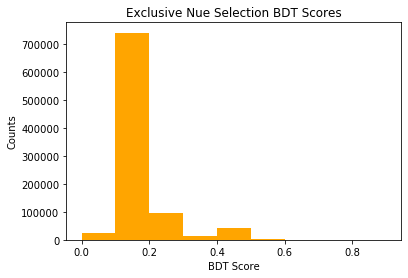

In [19]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [20]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

In [21]:
truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5"

truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)"

n_events here =  914729

22.868225
22
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_mc
Had to return early.
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_mc
Had to return early.
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 a

/home/alex/NuMI/PELEE/batch_plotter_alex.py:1174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  nue_fig = plt.figure(figsize=(7, 5))


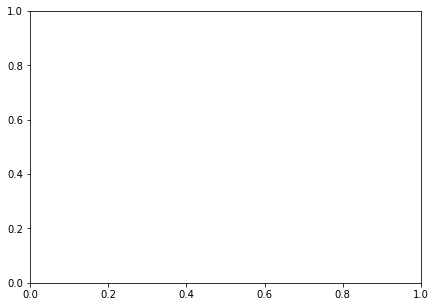

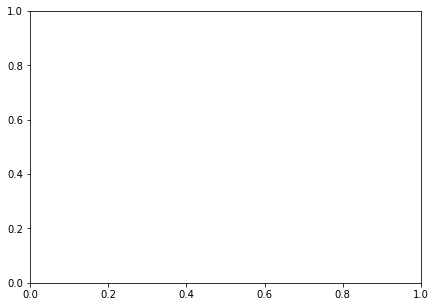

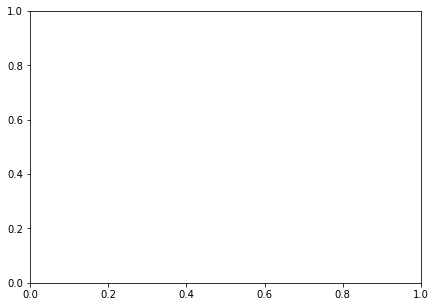

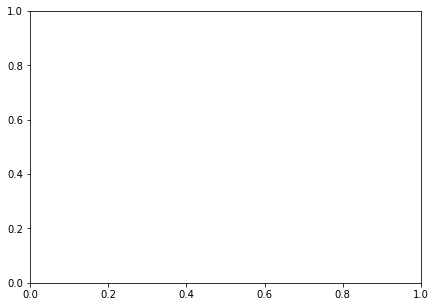

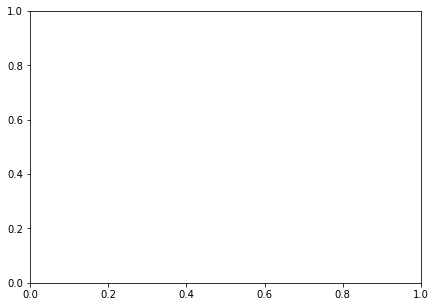

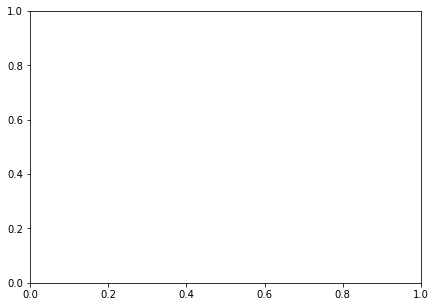

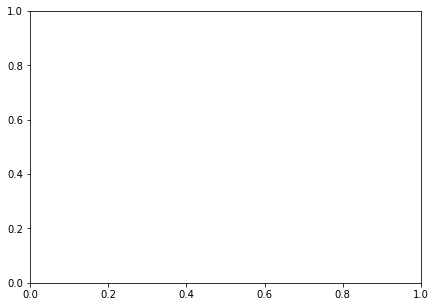

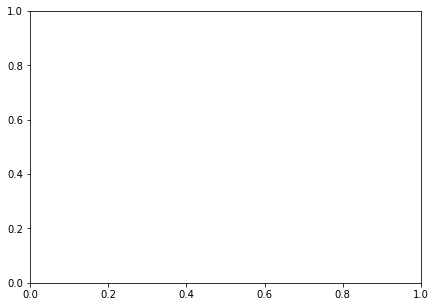

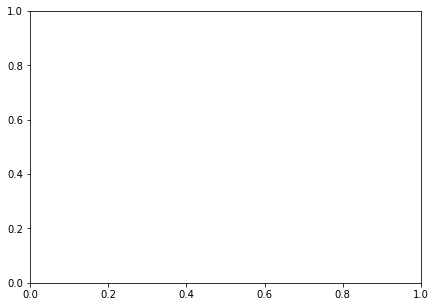

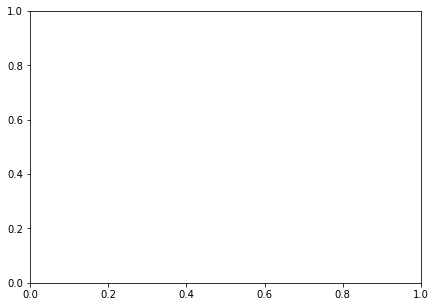

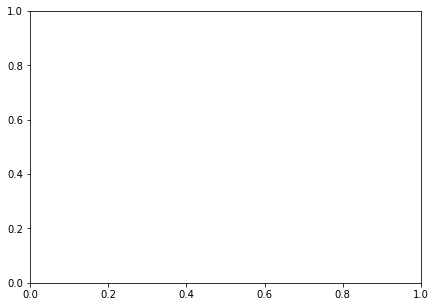

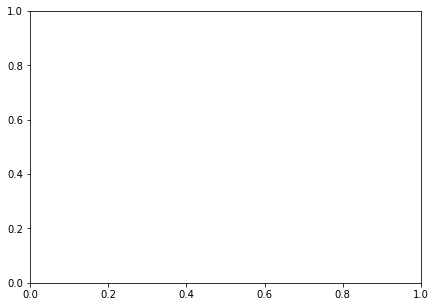

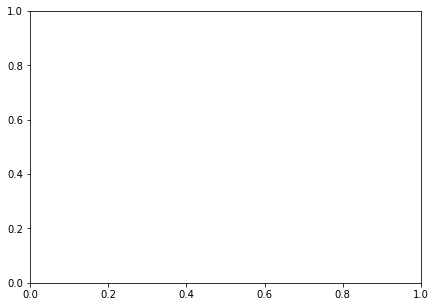

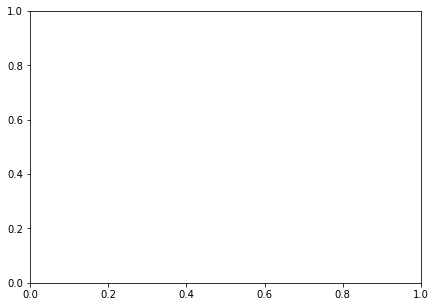

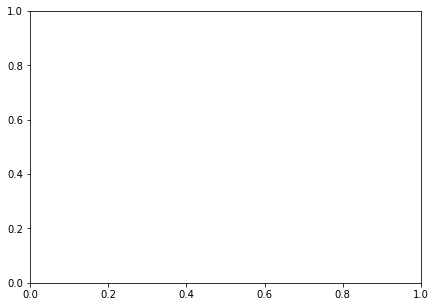

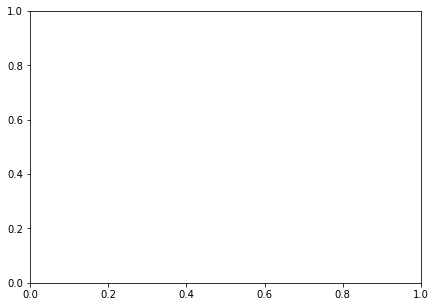

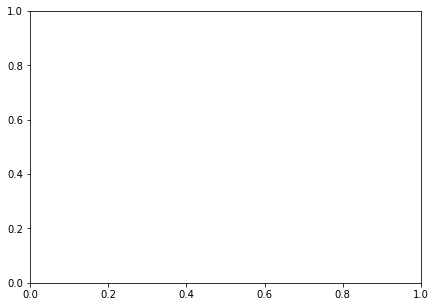

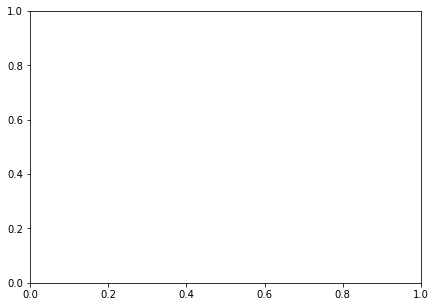

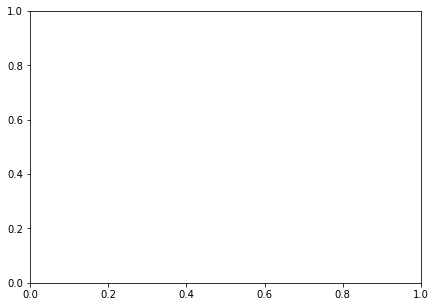

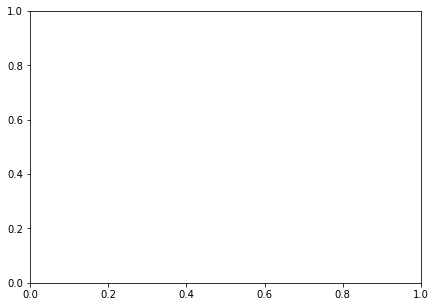

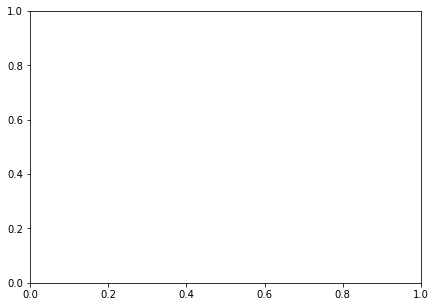

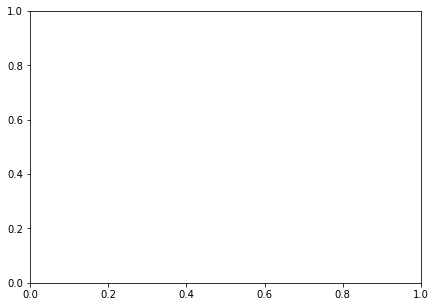

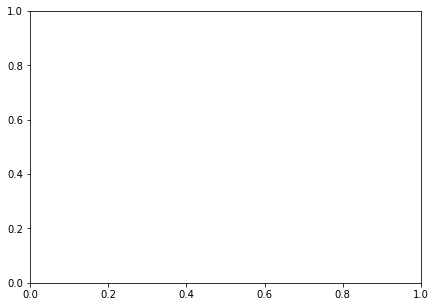

In [22]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        #"nue_nue": nue_nue
        "nue_mc": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    mcratio   = pot/2.33652e+21 

    # NUE
    weights = { #full sample mc = 0.38
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #BDT


    #Now check on a variable

    #Remember to change the plotter keys between truth and mc

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]

    #ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
    #ax1.set_yscale("log")
    #fig.tight_layout()
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)
    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/tmp/ipykernel_3455/2090322912.py:4: RuntimeWarning: More th

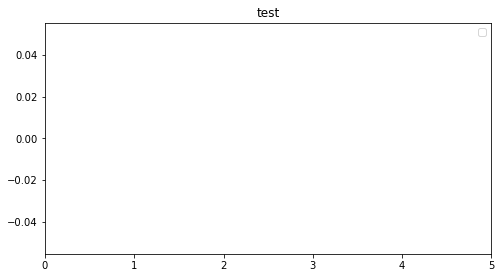

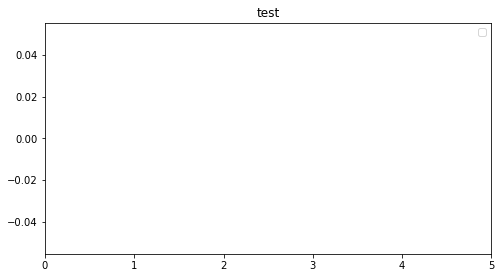

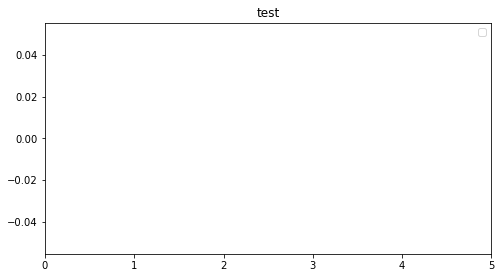

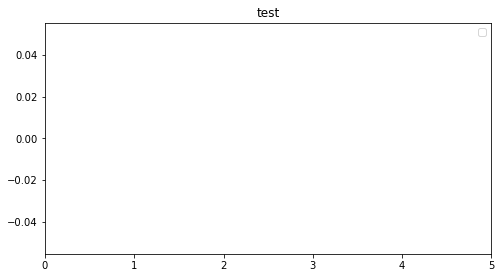

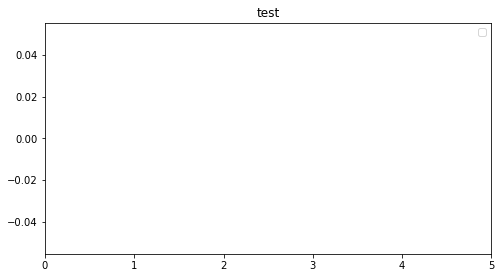

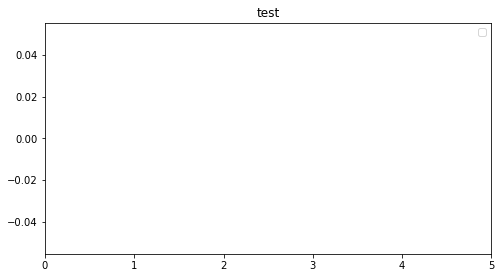

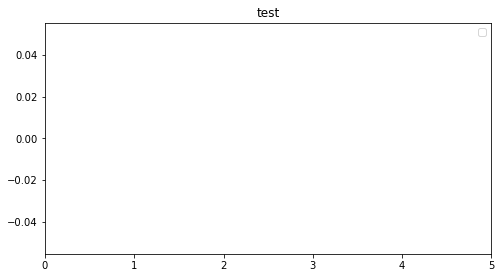

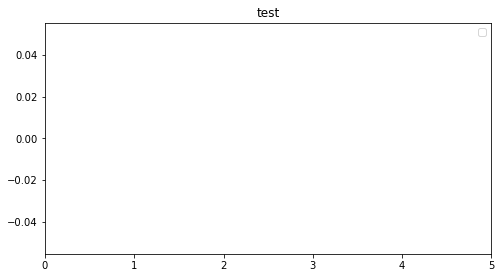

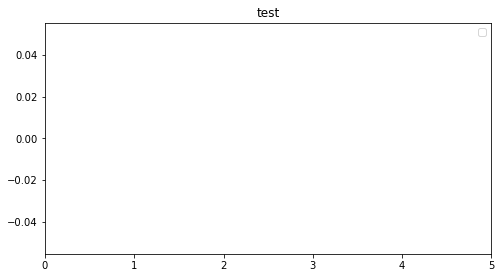

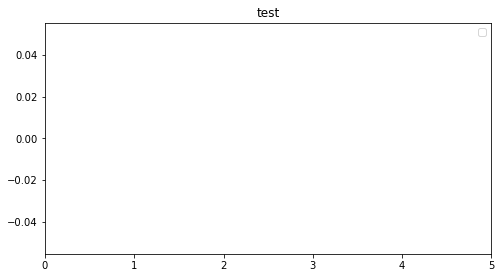

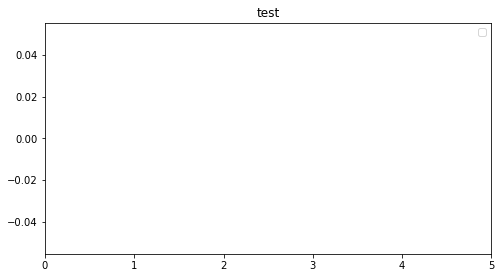

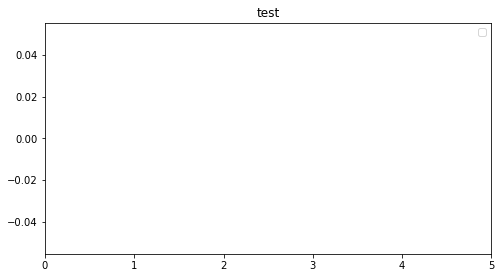

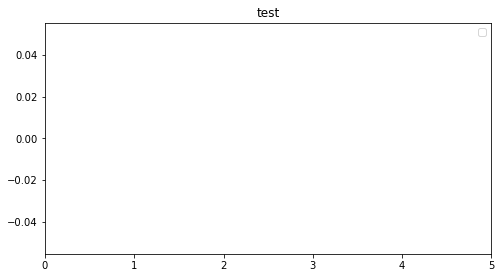

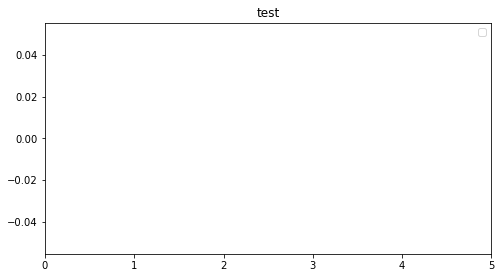

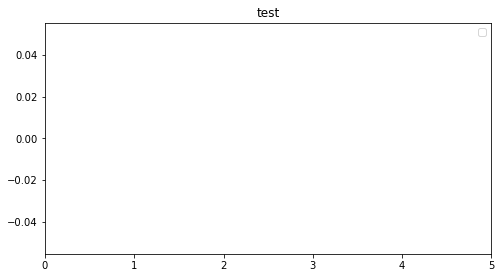

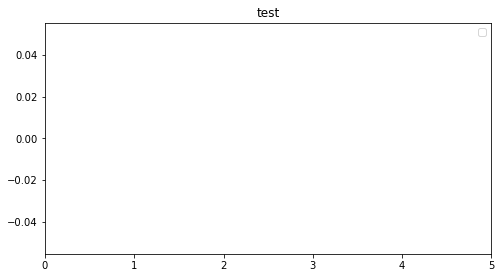

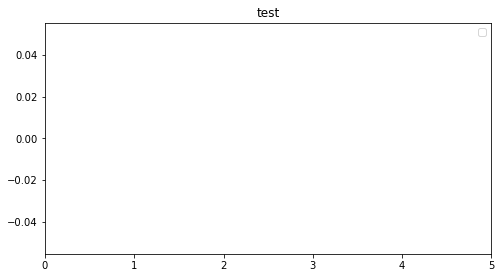

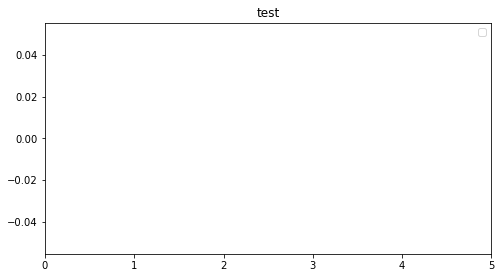

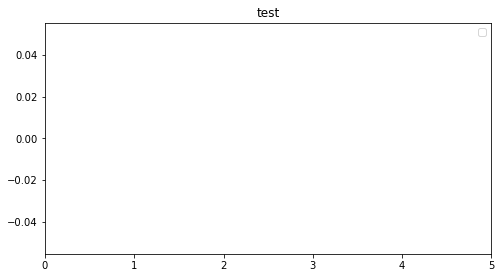

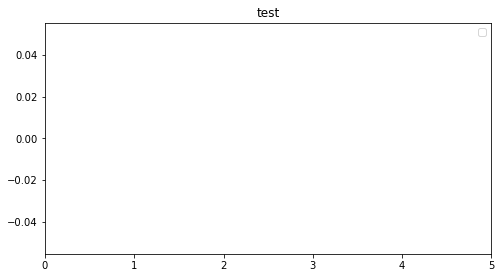

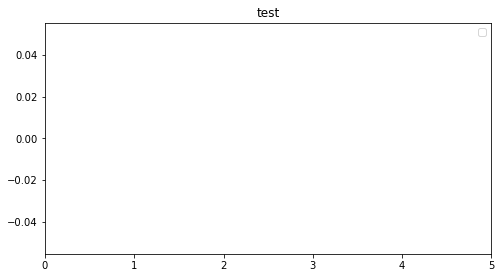

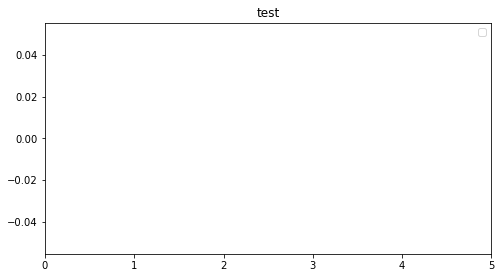

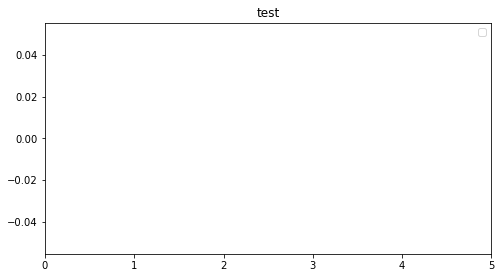

In [23]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()


In [24]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

No handles with labels found to put in legend.


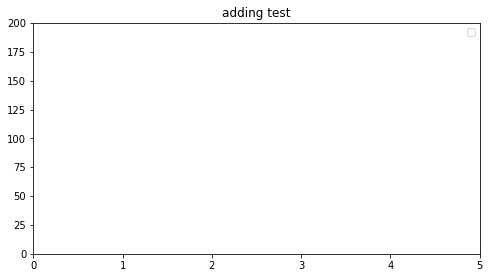

In [25]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$",
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 200])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()



In [26]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 1

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [27]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

#presamp
vars_tot_df.to_csv('nue_mc_varstot.csv')
weights_tot_df.to_csv('nue_mc_weightstot.csv')

#full
vars_tot_df.to_csv('nue_mc_varstot_full.csv')
weights_tot_df.to_csv('nue_mc_weightstot_full.csv')

### Stat Errors

In [28]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 

    
    weights = {
                "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  914729

22.868225
22
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_mc

err nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_mc

err nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue mc: 
[0. 0. 0. 0. 0. 0. 0.

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_mc

err nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_mc

err nue mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue mc: 
[0. 0. 

In [29]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

nue_mc_stat_errs = total_errs

#####################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_mc_stat_errs_selected = total_sels

total errs =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
total selected =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [30]:
np.savetxt("nue_mc_stat_errs_full.csv", 
           nue_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_mc_stat_errs_selected_full.csv", 
           nue_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

### sys errs - nue mc

In [31]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_mc.iloc[start:end]

    samples = {
        "nue_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21
    
    weights = {
        "nue_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    n_cv_tot, n_tot, nue_cov_b = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)

n_events here =  914729

22.868225
22
{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 20
extra query added.
Returning
--------------------------

{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 20
extra query added.
Returning
--------------------------

{'nue_mc': 0.08559738414394057}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 a

In [74]:
"""
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_nue_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_nue_mc_ppfx.append(sum(masterlist[a]))

final_ncvs_nue_mc_ppfx = sum(n_cv_tots)

#need to add 7 together to make a batch? sum? - over batch, not varation


cov_nue_mc_ppfx = np.empty([len(final_ns_nue_mc_ppfx[0]), len(final_ns_nue_mc_ppfx[0])])
cov_nue_mc_ppfx.fill(0)

Nuniverse = 10


for n_tot_pair in final_ns_nue_mc_ppfx:
    for n in n_tot_pair:
        for i in range(len(final_ns_nue_mc_ppfx[0])):
            for j in range(len(final_ns_nue_mc_ppfx[0])):
                cov_nue_mc_ppfx[i][j] += (n[i] - final_ncvs_nue_mc_ppfx[i]) * (n[j] - final_ncvs_nue_mc_ppfx[j])

cov_nue_mc_ppfx /= Nuniverse


print("")
print("cov  = ", cov_nue_mc_ppfx)
print("")
"""

'\nmasterlist = []\ntemplist = []\nfor i in range((len(n_tots[0]))):\n    masterlist.append(templist)\n    templist = []\n    for j in range(len(n_tots)):\n        templist.append(n_tots[j][i])\nmasterlist.append(templist)\n\n#need to sum each part of the masterlist into one pair of arrays now\nmasterlist.pop(0)\nfinal_ns_nue_mc_ppfx = []\n\nfor a in range(len(masterlist)):\n    #print(sum(masterlist[a]))\n    final_ns_nue_mc_ppfx.append(sum(masterlist[a]))\n\nfinal_ncvs_nue_mc_ppfx = sum(n_cv_tots)\n\n#need to add 7 together to make a batch? sum? - over batch, not varation\n\n\ncov_nue_mc_ppfx = np.empty([len(final_ns_nue_mc_ppfx[0]), len(final_ns_nue_mc_ppfx[0])])\ncov_nue_mc_ppfx.fill(0)\n\nNuniverse = 10\n\n\nfor n_tot_pair in final_ns_nue_mc_ppfx:\n    for n in n_tot_pair:\n        for i in range(len(final_ns_nue_mc_ppfx[0])):\n            for j in range(len(final_ns_nue_mc_ppfx[0])):\n                cov_nue_mc_ppfx[i][j] += (n[i] - final_ncvs_nue_mc_ppfx[i]) * (n[j] - final_ncvs

## Nue_Dirt

In [2]:
# Name of the TTree in the PeLEE Ntuples
tree = "NeutrinoSelectionFilter"
#cut samples
#DRT  = '/pre_samp/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND
#full sample
DRT  = '/neutrinoselection_filt_run1_dirt_overlay'        +ls.APPEND

#actually fetch datasets
nue_dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]

# Define a list that contains the data sets
uproot_v = [nue_dirt]

nue_variables = ["run", "sub", "evt",              
             "trk_score_v", "topological_score", "shr_score",
            "reco_nu_vtx_sce_x", "reco_nu_vtx_sce_y", "reco_nu_vtx_sce_z", "shr_tkfit_npoints",
            "CosmicIPAll3D", "hits_ratio", "contained_fraction",
            "shrmoliereavg", "shr_tkfit_dedx_U","shr_tkfit_dedx_V","shr_tkfit_dedx_Y",
            "shr_energy", "category", "slnunhits", "slnhits", "flash_time", "nu_pdg", "ccnc",
             "selected", "nslice", "shr_distance",
            "shr_tkfit_nhits_U", "shr_tkfit_nhits_V", "shr_tkfit_nhits_Y", "n_tracks_contained",
            "n_showers", "n_tracks", "shr_energy_cali", "n_showers_contained", "tksh_distance", "tksh_angle",
             "trkshrhitdist2", 'shrsubclusters0', 'shrsubclusters1', 'shrsubclusters2',
             "shr_energy_tot_cali", 'trk_energy_tot', 'nproton', 'trk_energy', "true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z", "nu_e"]


# These are examples of variables present in MC samples only
nue_varMC = ["true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "elec_e"]

#make the list unique (sometimes you repeat the variable name in the list, this takes care of that)
nue_variables = list(set(nue_variables))
print(nue_variables)



# These weights are needed to correctly calculate the CV for the MC    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
# These weights are needed to calculate the Flux, GENIE and Geant4 Systematics. 
# For NuMI weightsFlux should always be 1 (cause that's relevant for BNB).
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

nue_dirt = nue_dirt.pandas.df(nue_variables+nue_varMC + WEIGHTS + SYSTEMATICS, flatten=False)

['nproton', 'shr_energy_cali', 'nu_pdg', 'n_tracks', 'shrsubclusters0', 'shr_energy_tot_cali', 'shr_distance', 'shr_energy', 'trk_energy', 'true_nu_vtx_z', 'trk_energy_tot', 'true_nu_vtx_y', 'shr_tkfit_dedx_Y', 'shr_tkfit_nhits_Y', 'n_showers_contained', 'nslice', 'shrsubclusters2', 'shr_tkfit_npoints', 'hits_ratio', 'topological_score', 'slnunhits', 'shr_tkfit_nhits_U', 'sub', 'trkshrhitdist2', 'shr_tkfit_dedx_U', 'ccnc', 'run', 'nu_e', 'reco_nu_vtx_sce_z', 'reco_nu_vtx_sce_x', 'true_nu_vtx_x', 'contained_fraction', 'n_showers', 'tksh_distance', 'shrsubclusters1', 'category', 'shrmoliereavg', 'selected', 'CosmicIPAll3D', 'reco_nu_vtx_sce_y', 'shr_tkfit_dedx_V', 'n_tracks_contained', 'shr_score', 'slnhits', 'flash_time', 'tksh_angle', 'shr_tkfit_nhits_V', 'evt', 'trk_score_v']


In [3]:
# In the next cell, we are going to play with the value of the event weights. 
# Let's store the original ones in some "safe variable" in this cell first.
# So if we screw up, we don't have to re-load the humongous TTree: we'll have the original weights safely stored here
df_v = [nue_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [4]:
constructNuMISys = True

# We need to do this only for the MC samples (all data events weight = 1)
df_v = [nue_dirt]

for i,df in enumerate(df_v):
    # This portion cleans up the basic weights
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.
    # This portion cleans up the weights after the GENIE tune is applied
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1. #originally 100
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    
    # weightSplineTimesTuneTimesPPFX is our final weight: this is NuMI, so the final weight of the MC events needs 
    # to take into account the NuMI Flux re-weight called ppfx_cv to simulate NuMI events properly. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    # We also need to fix some cray cray weights in the GENIE systematics. 
    # This is a bit of a pain in the butt cause we have 600 universe (= 600 weights) for each event
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.


In [5]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [6]:
#This cell is about creating some new variables from the ones we have

import time
s = time.time()

#use all samples
df_v = [nue_dirt]


puppa1 = 'trk_score_v'


for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    trk_calo_energy_y_v = up.array('trk_calo_energy_y_v')
    trk_id              = up.array('trk_id')-1 # I think we need this -1 to get the right result
    c                   = up.array('n_tracks_contained')
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')

    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])
    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

    #print(trk_score_v.shape, len(trk_llr_pid_v))

    #dummy variables
    puppa_obj = []
    puppa_trk = []
    puppa_shw = []
    puppa_prt = [] 
    puppa_mu  = []
    
    for pidv, p in zip(trk_llr_pid_v,trk_score_v):
        N_obj         = 0
        N_recoTrks    = 0
        N_recoShowers = 0
        N_recoProtons = 0
        N_recoMuons   = 0
        if len(pidv) > 0:
            passPIDCut = (pidv <= 0)
            passTrkCut = (p    >= 0)
            protonCut  = (passPIDCut & passTrkCut) 
            muonCut    = (np.logical_not(passPIDCut) & passTrkCut) 
            N_obj         = len(passTrkCut)
            N_recoTrks    = np.count_nonzero(passTrkCut)
            N_recoShowers = np.count_nonzero(np.logical_not(passTrkCut))
            N_recoProtons = np.count_nonzero(protonCut)
            N_recoMuons   = np.count_nonzero(muonCut)
        puppa_obj.append(N_obj)
        puppa_trk.append(N_recoTrks)
        puppa_shw.append(N_recoShowers)    
        puppa_prt.append(N_recoProtons)
        puppa_mu .append(N_recoMuons)

    df['N_obj']           = puppa_obj
    df['N_recoTrks']      = puppa_trk
    df['N_recoShowers']   = puppa_shw
    df['N_recoProtons']   = puppa_prt
    df['N_recoMuons']     = puppa_mu
    
    trk_llr_pid_v_sel     = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_llr_pid_v,trk_id)])
    trk_energy_proton_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_energy_proton_v,trk_id)])
    trk_calo_energy_y_sel = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_calo_energy_y_v,trk_id)])
    trk_theta_proton_sel  = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_theta_proton_v,trk_id)])
    trk_phi_proton_sel    = awkward.fromiter([pidv[tid] if tid<len(pidv) else 9999. for pidv,tid in zip(trk_phi_proton_v,trk_id)])

    df['trkpid']          = trk_llr_pid_v_sel
    df['protonenergy']    = trk_energy_proton_sel
    df['trackcaloenergy'] = trk_calo_energy_y_sel
    df['subcluster']      = df['shrsubclusters0'] + df['shrsubclusters1'] + df['shrsubclusters2']
    #df['trkfit']          = df['shr_tkfit_npointsvalid'] / df['shr_tkfit_npoints']
    #df['anglediff_Y']     = np.abs(df['secondshower_Y_dir']-df['shrclusdir2'])
    #df['trkthetacos']     = np.cos(df['trk_theta'])

    df['protontheta']  = trk_theta_proton_sel
    df['protonphi']    = trk_phi_proton_sel

#calculate angles wrt NuMI reference frame
for i,df in enumerate(df_v):
    #df['shr_numi_Angle']    = df.apply( lambda x: GetNuMIAngle(x['shr_px'],x['shr_py'],x['shr_pz']) , axis=1)
    df['proton_numi_Angle'] = df.apply( lambda x: GetNuMIAnglePol(x['protonphi'],x['protontheta']) , axis=1)

    
#just prints out the time this cell takes
s2 = time.time()
print ("time to run: ",s2-s)

time to run:  63.172746658325195


In [7]:
for i,df in enumerate(df_v):
    df.loc[df['shrmoliereavg'].isna(),'secondshower_Y_dot'] = 9999.
    df.loc[df['secondshower_Y_dot'].isna(),'secondshower_Y_dot'] = 0.0 

In [8]:
df_v = [nue_dirt]
for i,df in enumerate(df_v):
    df.loc[:,'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_Y']
    df.loc[(df['shr_tkfit_nhits_U']>df['shr_tkfit_nhits_Y']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_U']
    df.loc[(df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_Y']) & (df['shr_tkfit_nhits_V']>df['shr_tkfit_nhits_U']),'shr_tkfit_dedx_max'] = df['shr_tkfit_dedx_V']
    

In [9]:
INTERCEPT = 0.0
SLOPE = 0.83

df_v = [nue_dirt]
# define some energy-related variables
for i,df in enumerate(df_v):
    df["reco_e"] = (df["shr_energy_tot_cali"] + INTERCEPT) / SLOPE + df["trk_energy_tot"]
#    df["reco_e_qe"] = 0.938*((df["shr_energy"]+INTERCEPT)/SLOPE)/(0.938 - ((df["shr_energy"]+INTERCEPT)/SLOPE)*(1-np.cos(df["shr_theta"])))
#    df["reco_e_rqe"] = df["reco_e_qe"]/df["reco_e"]

# and a way to filter out data
for i,df in enumerate(df_v):
    df["bnbdata"] = np.zeros_like(df["shr_energy"])
    df["extdata"] = np.zeros_like(df["shr_energy"])

In [10]:
# add back the cosmic category, for background only
df_v = [nue_dirt]
for i,df in enumerate(df_v):
    df.loc[(df['category']!=1)&(df['category']!=10)&(df['category']!=11)&(df['category']!=111)&(df['slnunhits']/df['slnhits']<0.2), 'category'] = 4
    


In [11]:
#########################################################
######## RUN THIS CELL ONLY ONE TIME ONLY ###############
#########################################################
# The flash time for the NuMI data stream needs to be adjusted a little bit (there are hardware offsets in data). 
# That's the reason behind these hard coded shifts
df_v = [nue_dirt]
for i,df in enumerate(df_v):
        df.loc[ :, 'flash_time' ] = df['flash_time' ] - 0.304



In [12]:
nue_dirt["is_signal"] = nue_dirt["category"] == 11

In [13]:
# Some quick clean up since some strange events get in there
nue_dirt   = nue_dirt.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [nue_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [14]:
reco_in_fv_query = "10<=reco_nu_vtx_sce_x<=246 and -106<=reco_nu_vtx_sce_y<=106 and 10<=reco_nu_vtx_sce_z<=1026"

BDT_PRE_QUERY = 'nslice==1'
BDT_PRE_QUERY += ' and ' + reco_in_fv_query
BDT_PRE_QUERY +=' and contained_fraction>0.9'
BDT_PRE_QUERY += ' and n_tracks_contained>0'
BDT_PRE_QUERY += ' and n_showers_contained==1'
BDT_PRE_QUERY += ' and shr_energy_tot_cali>0.07'
BDT_PRE_QUERY += ' and trk_energy>0.04' #added

BDT_LOOSE_CUTS = BDT_PRE_QUERY
BDT_LOOSE_CUTS += ' and shr_score<0.3'
BDT_LOOSE_CUTS += ' and trkpid<0.35'
BDT_LOOSE_CUTS += ' and shrmoliereavg<15'
BDT_LOOSE_CUTS += ' and shr_tkfit_dedx_Y<7'
BDT_LOOSE_CUTS += ' and tksh_distance<12'

In [15]:
# load bdt model 
bdt_model = xgb.Booster({'nthread': 4})
bdt_model.load_model('/home/alex/NuMI/bdt_FHC_oct2021_v3.model')

In [16]:
# NOW, apply the model to real data for data/MC comparisons

varlist = [
    "shr_score", "shrmoliereavg", "trkpid",
    "n_showers_contained", "shr_tkfit_dedx_Y", "tksh_distance",
    "tksh_angle", "subcluster", "trkshrhitdist2"]
#The training variables?

datasetlist = [nue_dirt]

for df in datasetlist:
    for column in varlist:
        df.loc[(df[column] < -1.0e37) | (df[column] > 1.0e37), column] = np.nan
        
    # create testing dmatrix 
    df_test = xgb.DMatrix(data=df[varlist])
    
    # apply the bdt selection
    preds = bdt_model.predict(df_test)
    
    # add columns for plotting 
    df['BDT_score'] = preds
    print(df.shape)

(483722, 95)


In [17]:
datasets_bdt = nue_dirt

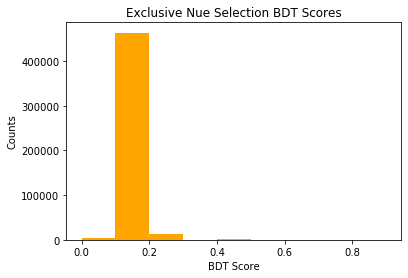

In [18]:
import matplotlib.pyplot as plt
import matplotlib

bins = np.arange(0, 1.0, 0.1)
gen = plt.hist(datasets_bdt['BDT_score'], bins, color='orange')
plt.xlabel("BDT Score")
plt.ylabel("Counts")
plt.title("Exclusive Nue Selection BDT Scores")
plt.show()

In [19]:
NUE_SEL_QUERY = BDT_LOOSE_CUTS
NUE_SEL_QUERY += ' and BDT_score > 0.575'

In [20]:
truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5"

truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)"

n_events here =  483722

48.3722
48
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_dirt
Had to return early.
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_dirt
Had to return early.
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x

/home/alex/NuMI/PELEE/batch_plotter_alex.py:1174: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  nue_fig = plt.figure(figsize=(7, 5))


Had to return early.
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_dirt
Had to return early.
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_dirt
Had to return early.
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and t

Had to return early.
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_dirt
Had to return early.
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  nue_dirt
Had to return early.
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and t

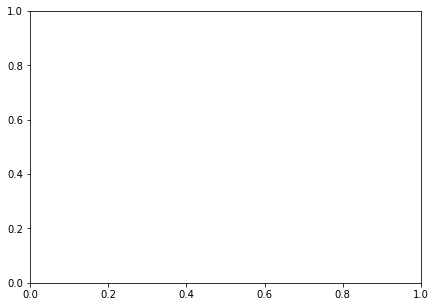

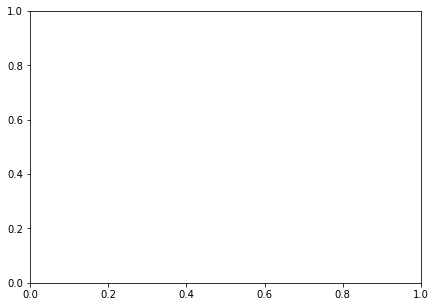

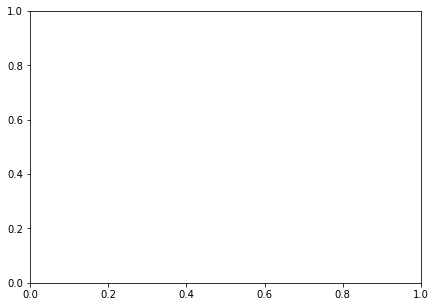

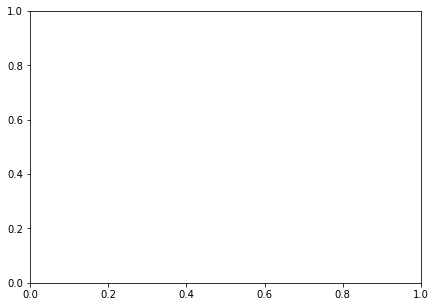

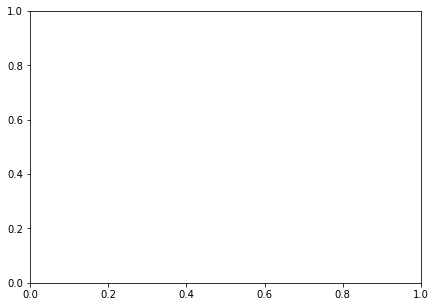

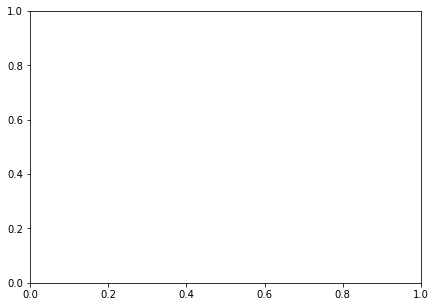

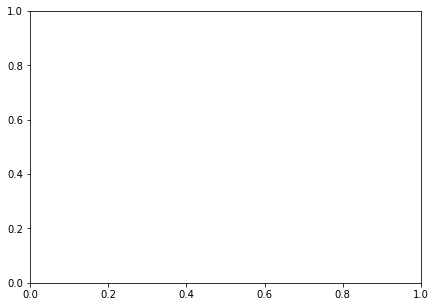

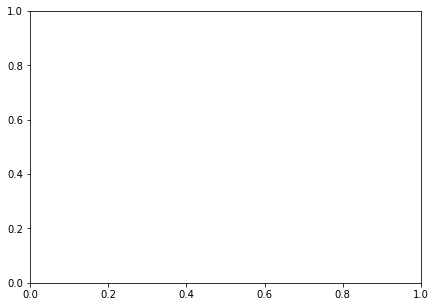

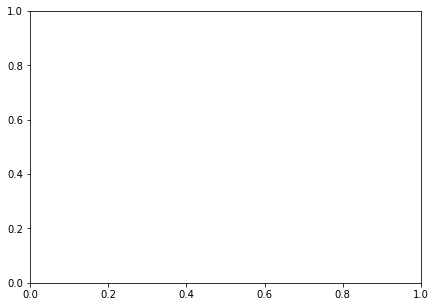

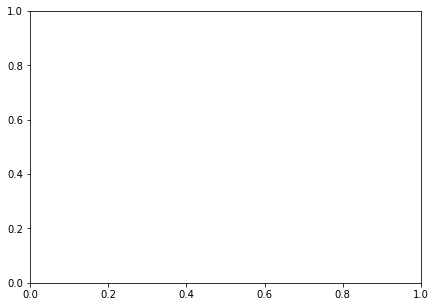

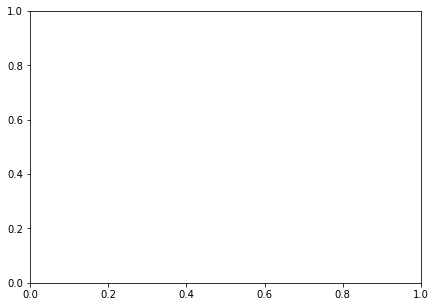

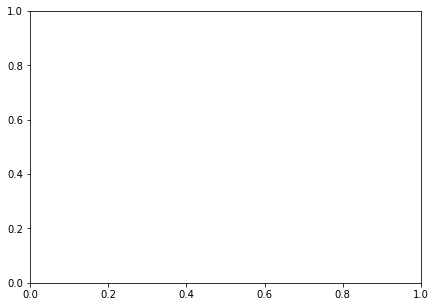

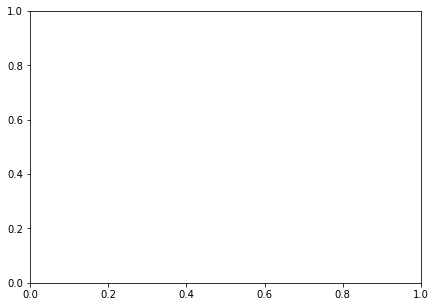

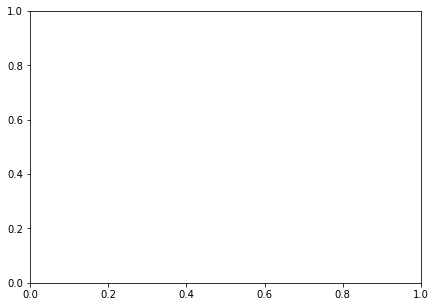

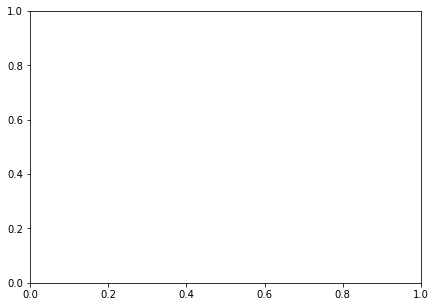

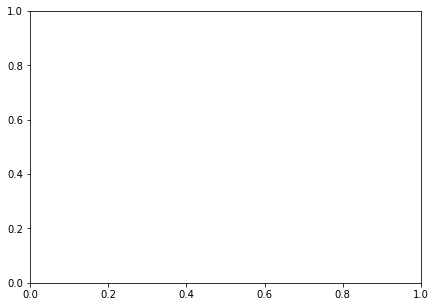

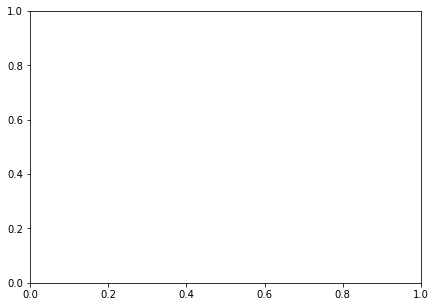

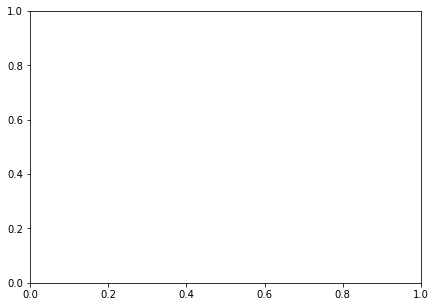

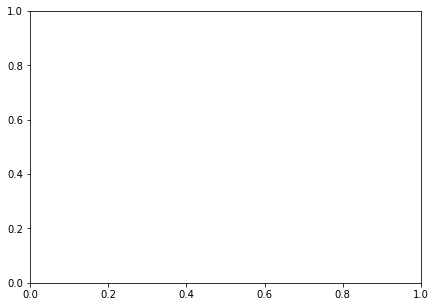

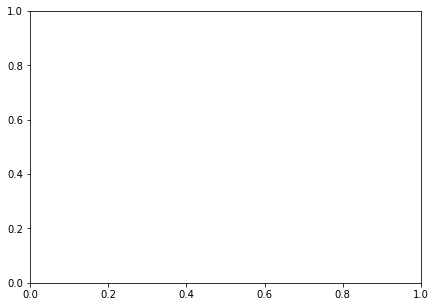

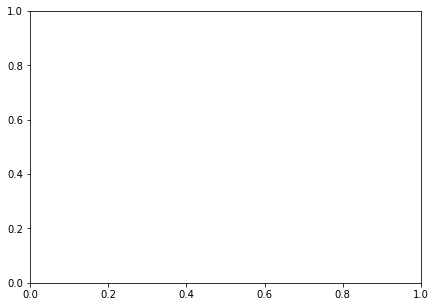

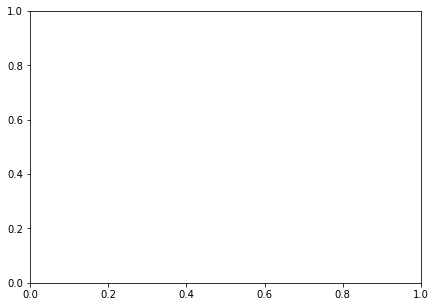

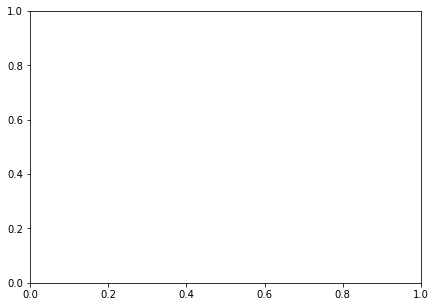

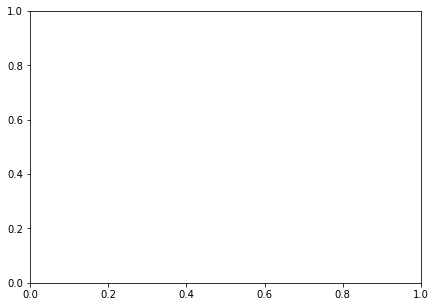

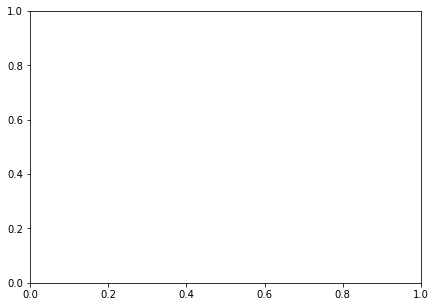

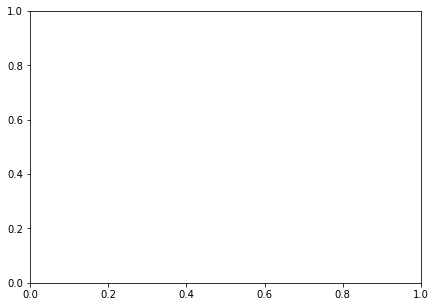

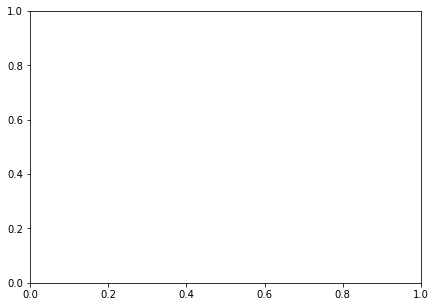

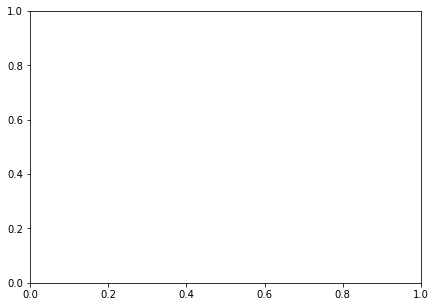

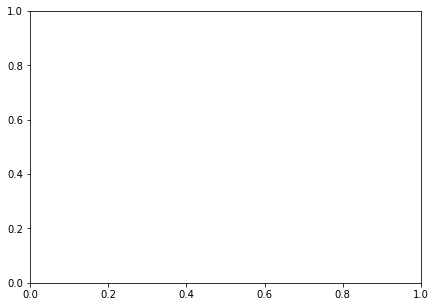

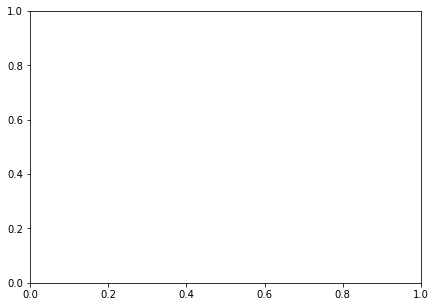

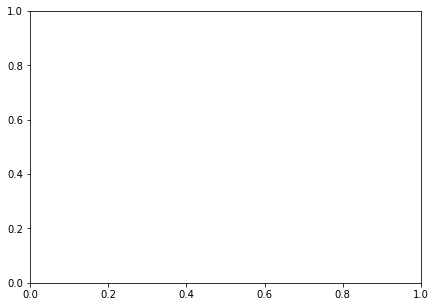

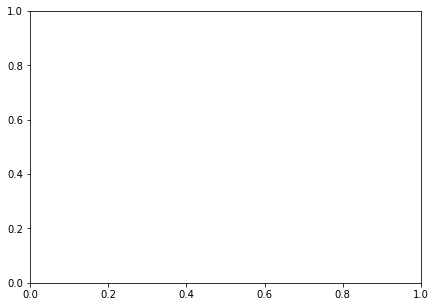

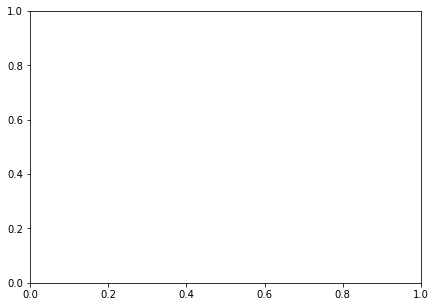

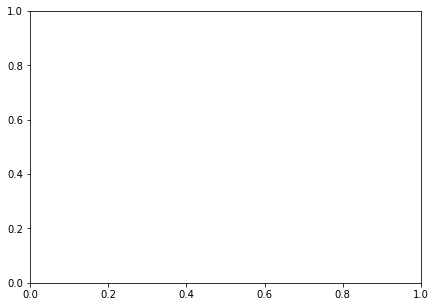

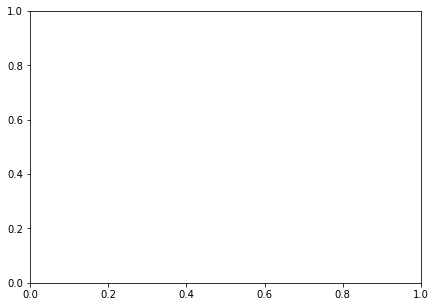

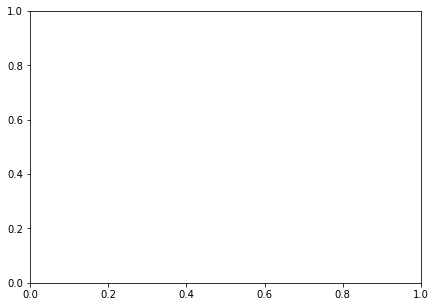

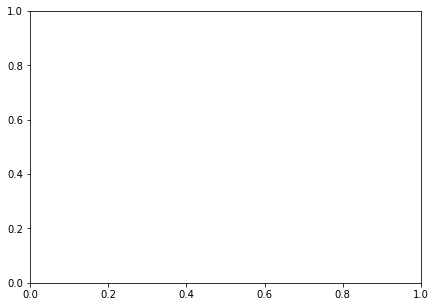

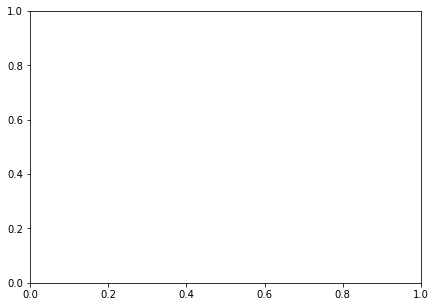

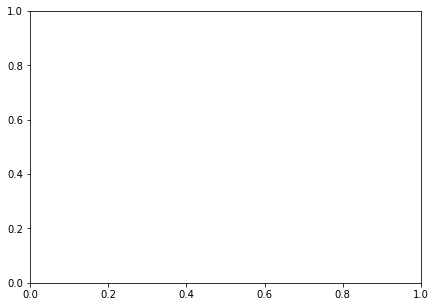

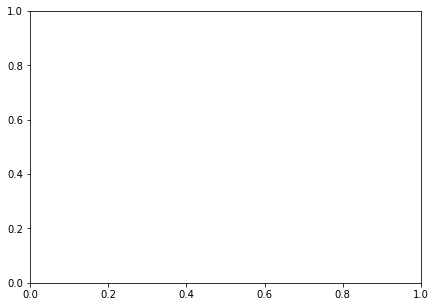

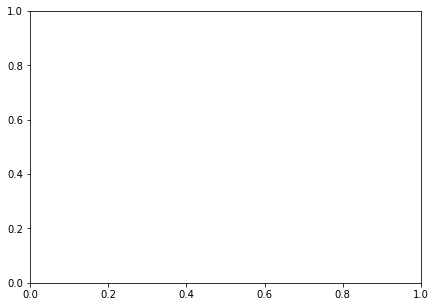

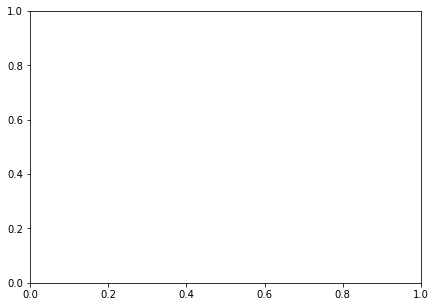

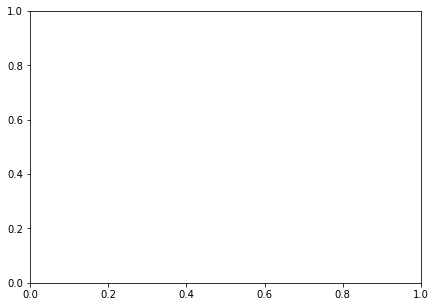

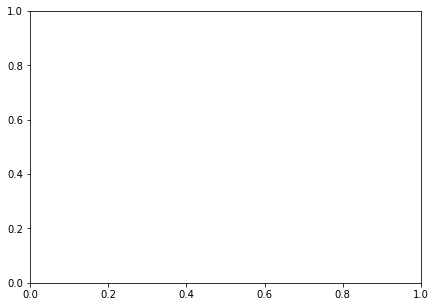

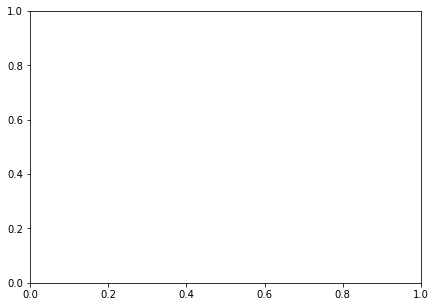

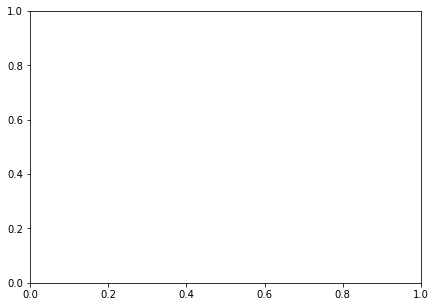

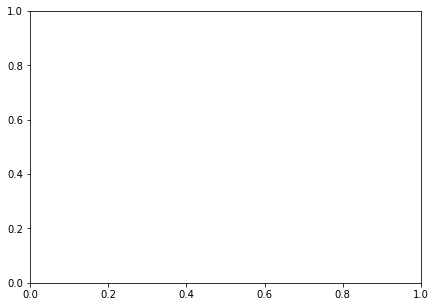

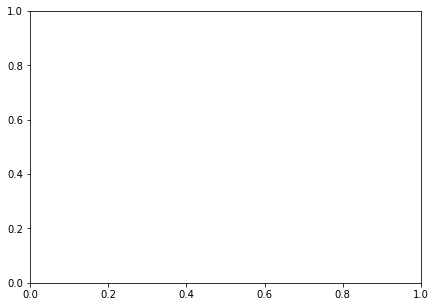

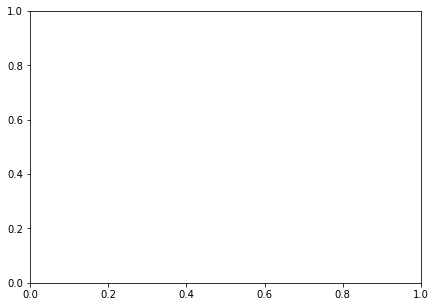

In [21]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    dirtratio = pot/1.42143e+21
    scalingDRT = 0.35

    # NUE
    weights = { #full sample mc = 0.38
                "nue_dirt": dirtratio* SPLIT * scalingDRT, #set0
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #BDT


    #Now check on a variable

    #Remember to change the plotter keys between truth and mc

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]

    #ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
    #ax1.set_yscale("log")
    #fig.tight_layout()
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)
    

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
/tmp/ipykernel_4730/222795536.py:4: RuntimeWarning: More tha

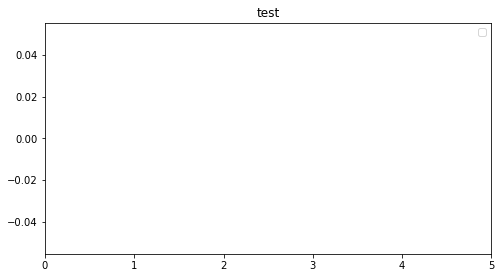

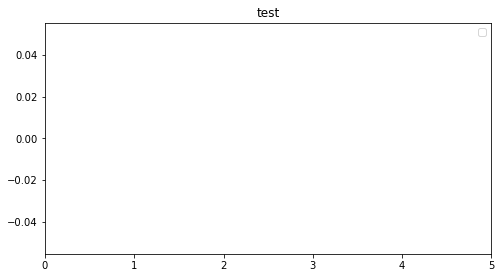

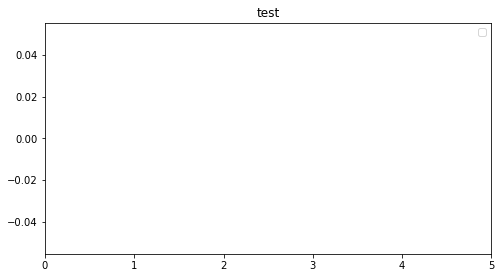

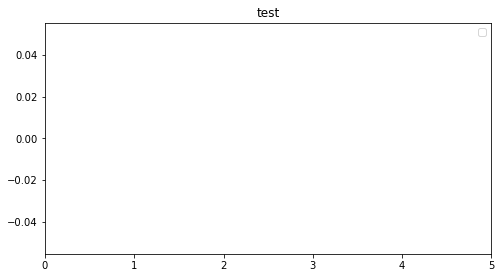

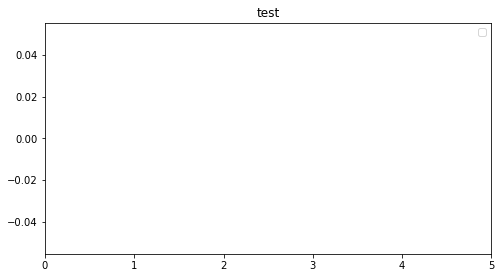

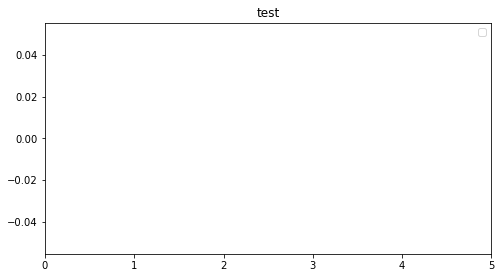

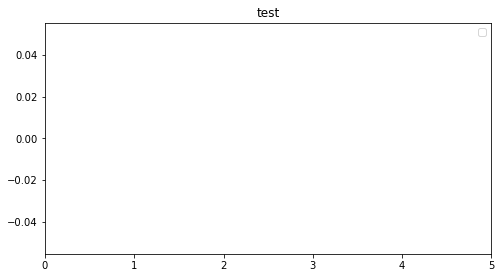

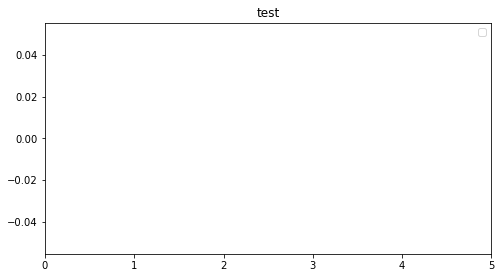

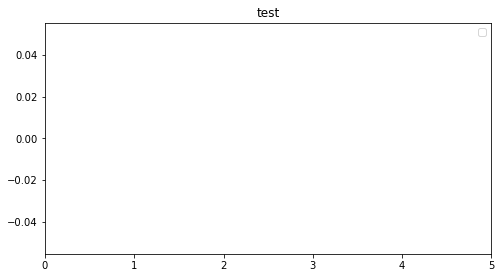

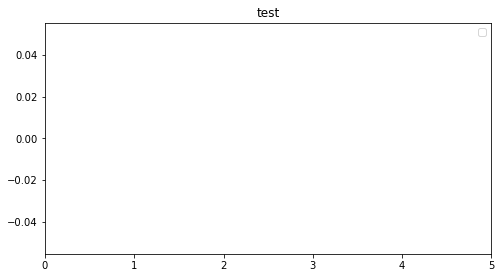

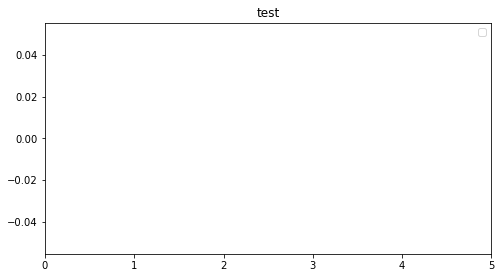

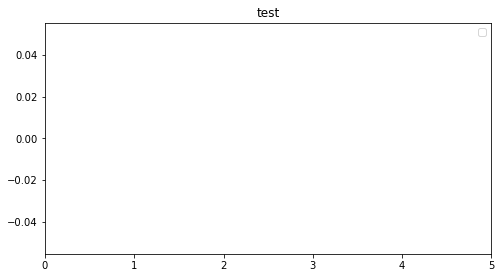

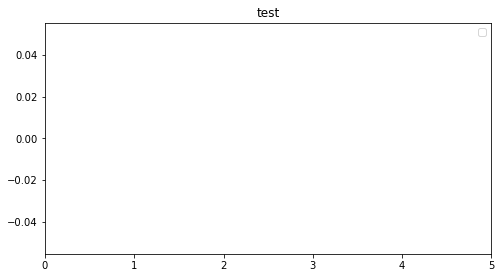

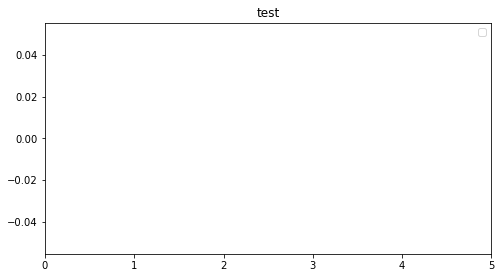

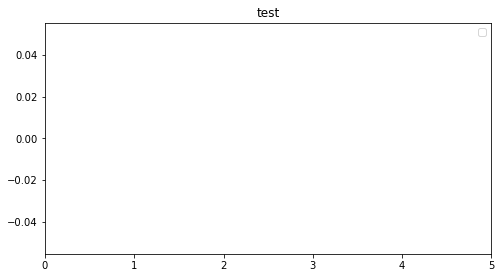

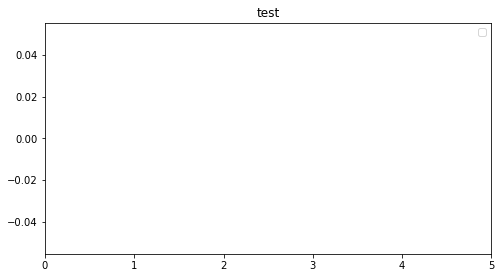

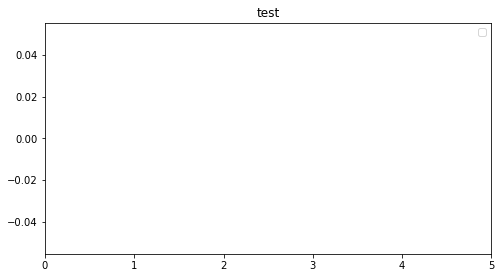

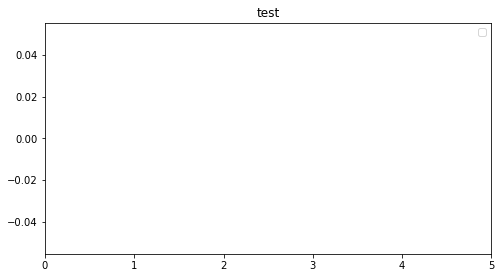

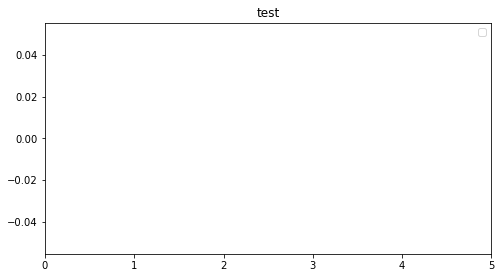

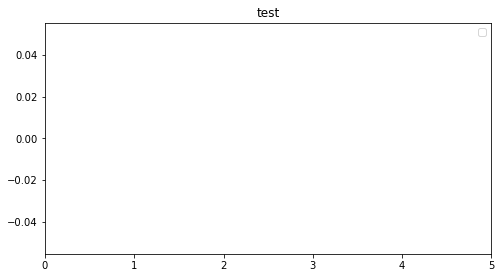

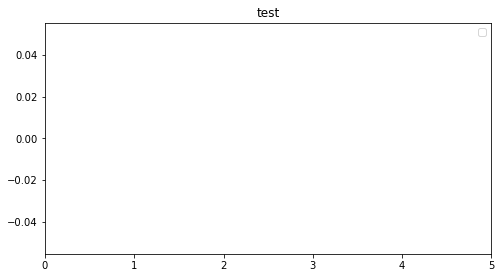

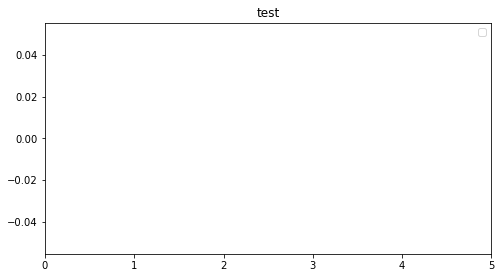

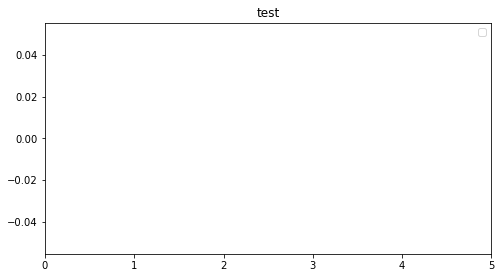

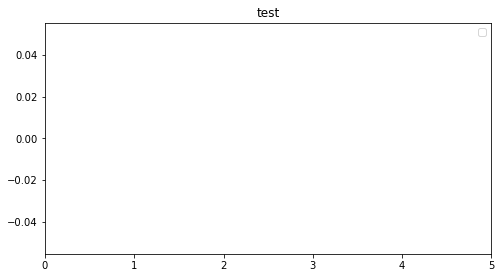

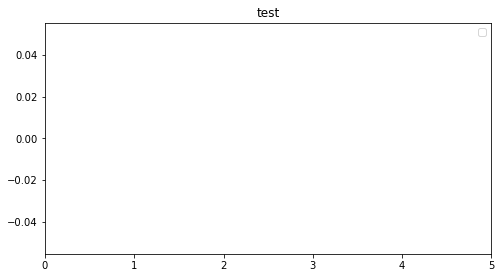

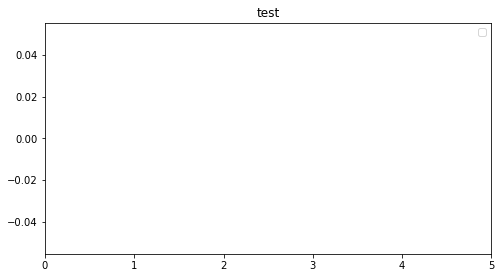

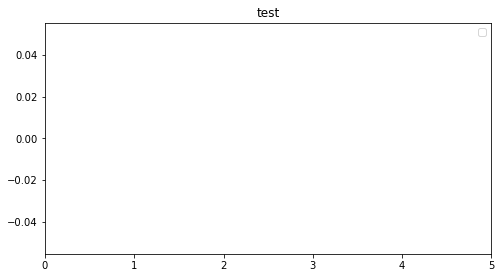

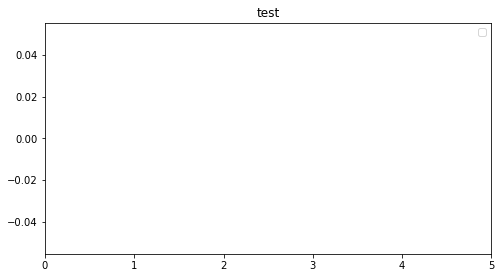

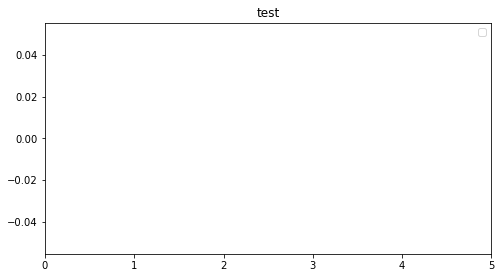

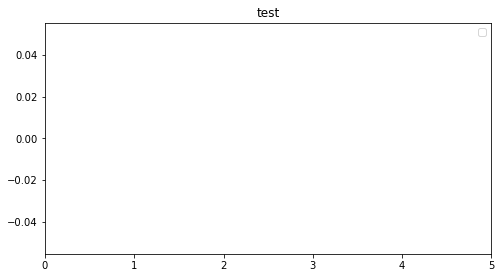

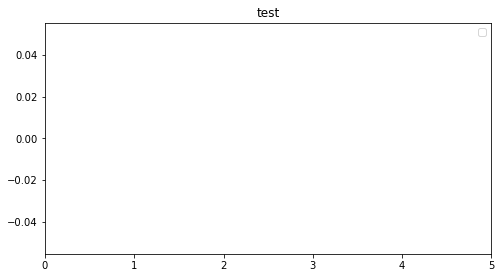

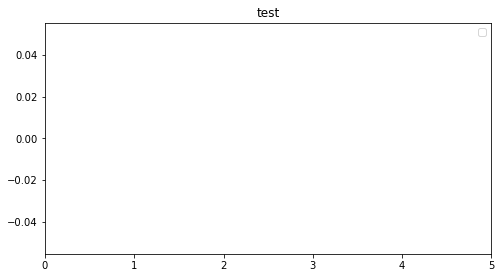

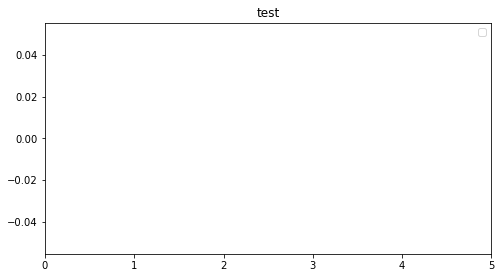

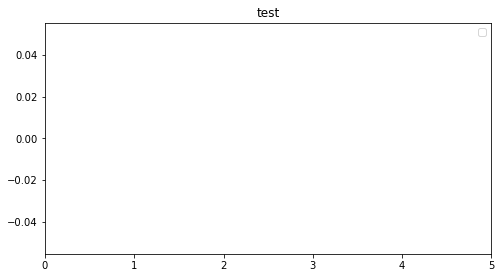

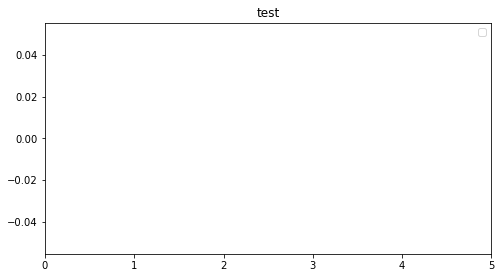

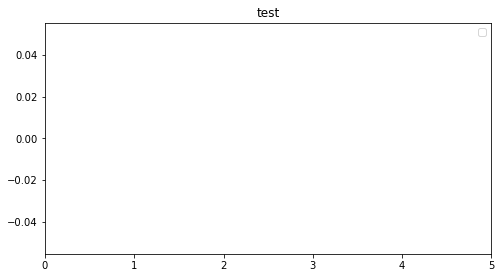

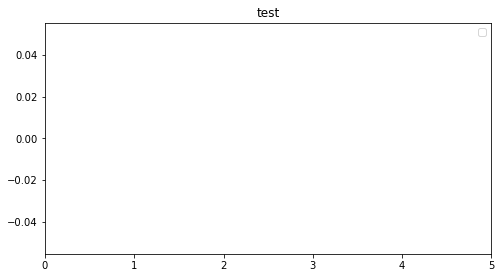

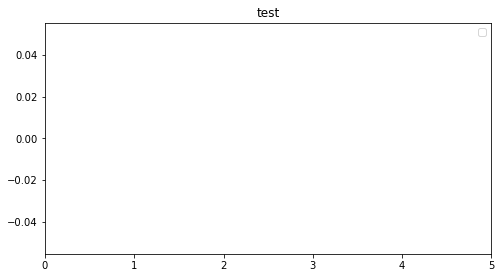

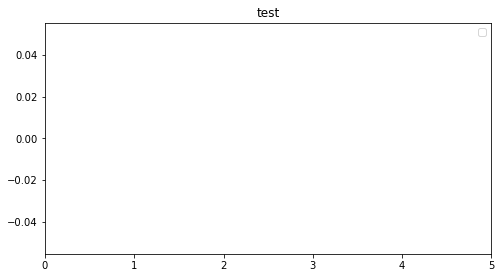

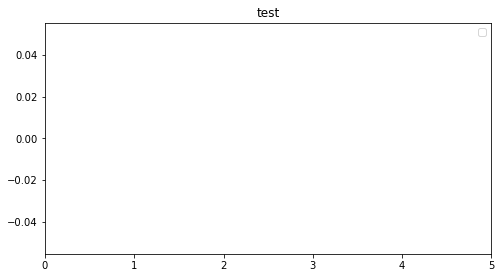

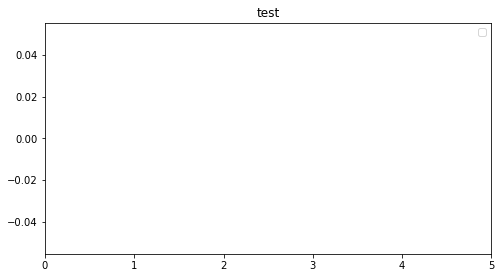

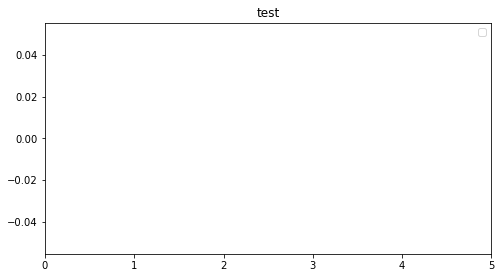

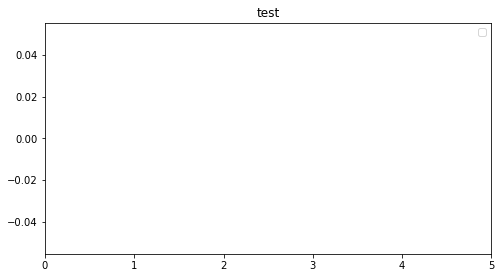

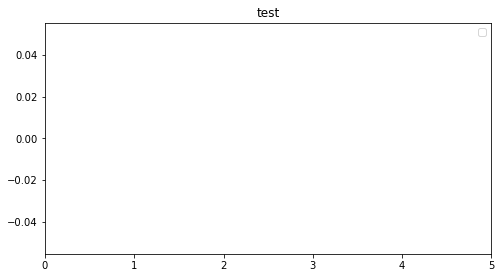

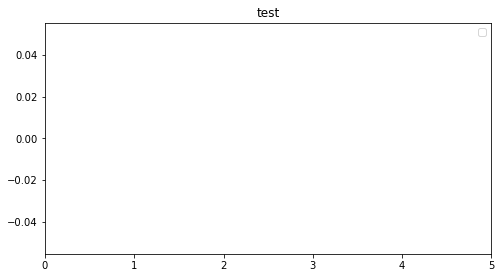

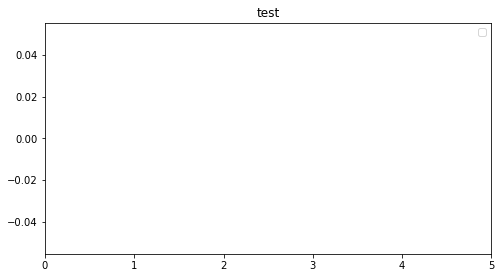

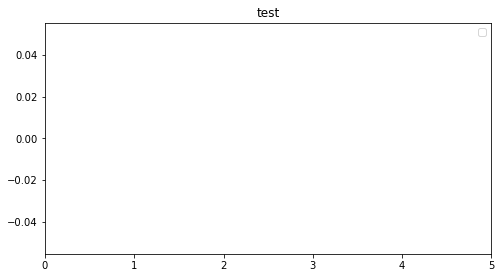

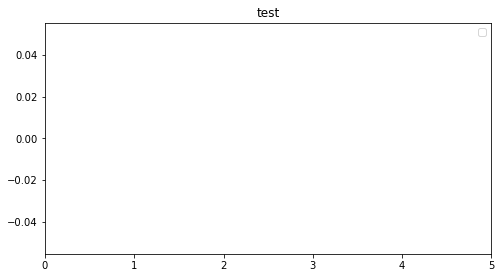

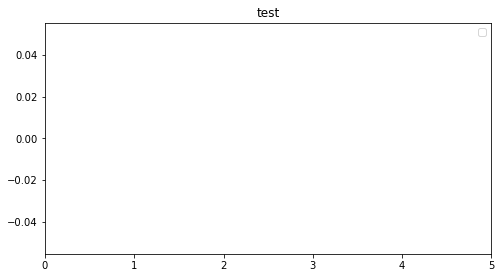

In [22]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()

In [23]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

No handles with labels found to put in legend.


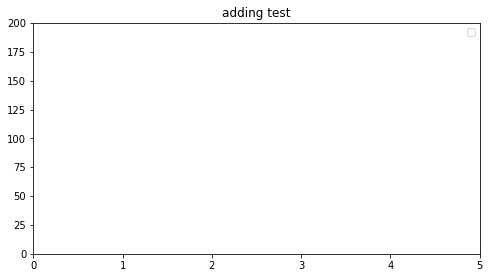

In [24]:
labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 200])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [25]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 1

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [26]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

#presamp
vars_tot_df.to_csv('nue_dirt_varstot.csv')
weights_tot_df.to_csv('nue_dirt_weightstot.csv')

#full
vars_tot_df.to_csv('nue_dirt_varstot_full.csv')
weights_tot_df.to_csv('nue_dirt_weightstot_full.csv')

### Stat Errors

In [27]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = nue_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 10000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = nue_dirt.iloc[start:end]

    samples = {
        "nue_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    scalingDRTnue = 0.35

    
    weights = {
                "nue_dirt": dirtratio* SPLIT * scalingDRTnue
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_nue,
        currentsample = "nue_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  483722

48.3722
48
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_dirt

err nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_dirt

err nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue dirt: 
[0. 0

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_dirt

err nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_dirt

err nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys 


err nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  nue_dirt

err nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys nue dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'nue_dirt': 0.049246181662128984}
(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 


In [28]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errs = ", total_errs)

nue_dirt_stat_errs = total_errs

#########################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

nue_dirt_stat_errs_selected = total_sels

total errs =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
total selected =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [29]:
np.savetxt("nue_dirt_stat_errs_full.csv", 
           nue_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("nue_dirt_stat_errs_selected_full.csv", 
           nue_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

### Sys Errs Nue Dirt

Dirt does not get sys errors calculated.

## Now for Numu

## Numu_Mc

In [2]:
tree = "NeutrinoSelectionFilter"

#presamp
#NU   = '/pre_samp/prodgenie_numi_uboone_overlay_fhc_mcc9_run1_v28_all_snapshot'    +ls.APPEND
#full
NU   = '/neutrinoselection_filt_run1_overlay'    +ls.APPEND #newTune

numu_mc   = uproot.open(ls.ntuple_path+NU +".root")[ls.fold][tree]


uproot_v = [numu_mc] 


numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nproton",
        "reco_e",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial",
        #"theta", # angle between incoming and outgoing leptons in radians
    ]

numu_varMC = ["nu_e", "true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz", "theta", "mc_pdg", "mc_px", "mc_py", "mc_pz"]

#make the list unique
numu_variables = list(set(numu_variables))
print(numu_variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['evnunhits', 'slpdg', 'evt', '_opfilter_pe_beam', 'pi0_e', 'backtracked_pdg', 'pion_e', 'reco_nu_vtx_y', 'sub', 'nproton', 'reco_nu_vtx_z', 'ccnc', '_opfilter_pe_veto', 'reco_nu_vtx_sce_z', 'true_e_visible', 'pi0truth_elec_etot', 'reco_nu_vtx_sce_y', 'muon_e', 'slnhits', 'interaction', 'trk_llr_pid_score_v', 'mc_pdg', 'npion', 'reco_nu_vtx_x', 'reco_e', 'npi0', 'slclustfrac', 'isVtxInFiducial', 'CosmicIP', 'reco_nu_vtx_sce_x', 'slnunhits', 'nslice', 'flash_pe', 'nu_pdg', 'topological_score', 'run', 'CosmicIPAll3D', 'CosmicDirAll3D', 'category']


In [ ]:
import pandas as pandas

mc_var   = numu_variables + WEIGHTS + MCFVARS + SYSTEMATICS + PPFX+numu_varMC

# This needs modifications (add variables from above)
uproot_v = [numu_mc] 
var_v    = [mc_var] 


for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_mc = CVDF
        

In [4]:
numu_mc   = numu_mc.query('(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2')

In [5]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']
    #print(df['mc_pdg'])
    #print(df['mc_px'])

/tmp/ipykernel_3219/1671020018.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
/tmp/ipykernel_3219/1671020018.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ 'currentweight' ] = df['weightSplineTimesTune']


In [6]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
     # Cray cray weight fix
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.


/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/tmp/ipykernel_3219/1735850224.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
/tmp/ipykernel_3219/1735850224.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_in

In [7]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

/tmp/ipykernel_3219/2298686548.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
/tmp/ipykernel_3219/2298686548.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
/tmp/ipykernel_3219/2298686548.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentati

In [8]:
df_v = [numu_mc]
scaleFlat = 0
#removeGenieTune = False
for i,df in enumerate(df_v):
    if scaleFlat == 1:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ] 
        df.loc[ df['npi0'] > 0, 'weightSplineTimesTuneTimesPPFX' ] =  (df['weightSplineTimesTuneTimesPPFX'] * 0.759)
    elif scaleFlat == 2:
        df['weightSplineTimesTune'] = df[ 'currentweight' ] 
        pi0emax = 0.6
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] < pi0emax) , 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*df['pi0_e'])
        df.loc[ (df['pi0_e'] > 0.1) & (df['pi0_e'] >= pi0emax), 'weightSplineTimesTuneTimesPPFX'] = df['weightSplineTimesTuneTimesPPFX']*(1.-0.4*pi0emax)
    elif scaleFlat == 0:
        df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]

/tmp/ipykernel_3219/2669013565.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['weightSplineTimesTuneTimesPPFX'] = df[ 'currentweight' ]


In [9]:
df_v = [numu_mc]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

/tmp/ipykernel_3219/2508238644.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[ 'noW' ] = 1


In [10]:
df_v = [numu_mc]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

/tmp/ipykernel_3219/2833717817.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
/tmp/ipykernel_3219/2833717817.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["extdata"] = np.zeros_like(df["isVtxInFiducial"])


In [ ]:
def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)


In [15]:
numu_mc["is_signal"]   = numu_mc["category"] == 2
#print(numu_mc["is_signal"])

/tmp/ipykernel_7670/921779923.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numu_mc["is_signal"]   = numu_mc["category"] == 2


In [16]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [17]:
def vectorFromNuMITarget(vtxX,  vtxY, vtxZ):
    numiTarget      = np.array([-31387.58422, -3316.402543, -60100.2414])
    nuInteraction   = np.array([vtxX,  vtxY, vtxZ])
    directionVector = nuInteraction - numiTarget
    return directionVector

def angleFromNuMITarget(vtxX,  vtxY, vtxZ, thetaBNB, phiBNB):
    v1 = vectorFromNuMITarget(vtxX,  vtxY, vtxZ)  
    norm = np.linalg.norm(v1)
    v1 = v1/norm
    v2 = [np.cos(phiBNB)*np.sin(thetaBNB),np.sin(phiBNB)*np.sin(thetaBNB), np.cos(thetaBNB) ]
    dot_product = np.dot(v1, v2)
    angle = np.arccos(dot_product)
    return angle #dot_product # angle*180/3.14159265



angleFromNuMITarget(1,1,1,1.4,3.)

1.8690124908136228

In [18]:
for i,df in enumerate(df_v):
    df["muon_px"] = np.nan
    df["muon_py"] = np.nan
    df["muon_pz"] = np.nan
    for j in range(len(df["mc_pdg"])):
    #for j in range(2):
        #print(df["mc_pdg"].iloc[j][0])
        #print(df["mc_px"].iloc[j])
        #print(df["mc_py"].iloc[j])
        #print(df["mc_pz"].iloc[j])
        pdg_vector = df["mc_pdg"].iloc[j][0]
        px_vector = df["mc_px"].iloc[j]
        py_vector = df["mc_py"].iloc[j]
        pz_vector = df["mc_pz"].iloc[j]
        result = np.where(pdg_vector==13)[0]
        if np.size(result):
            df.loc[j, "muon_px"] = px_vector[result][0]
            df.loc[j, "muon_py"] = py_vector[result][0]
            df.loc[j, "muon_pz"] = pz_vector[result][0]   
            
    print(df["muon_px"])

/tmp/ipykernel_7670/3874850383.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["muon_px"] = np.nan
/tmp/ipykernel_7670/3874850383.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["muon_py"] = np.nan
/tmp/ipykernel_7670/3874850383.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#return

entry
0        0.266320
1        0.207083
24       0.143531
43      -0.150616
61      -0.046916
           ...   
74193    0.466373
74194    0.717919
74195    0.581640
74196    0.356888
74197    0.442396
Name: muon_px, Length: 142477, dtype: float64


In [45]:
for i,df in enumerate(df_v):
    df['targetP']     = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'] + df['muon_pz']*df['muon_pz'])
    df['targetPt']    = np.sqrt(df['muon_px']*df['muon_px'] + df['muon_py']*df['muon_py'])
    df['targetTheta'] = np.arccos(df['muon_pz']/df['targetP'] )
    df['targetPhi']   = np.arctan2(df['muon_py'],df['muon_px'])
    df['nu_Angle_Numi_Elec'] = df.apply( lambda x: angleFromNuMITarget(x['true_nu_vtx_sce_x'],x['true_nu_vtx_sce_y'],x['true_nu_vtx_sce_z'], x['targetTheta'],x['targetPhi']) , axis=1)
    df['cosNu_Angle_Numi_Elec'] = np.cos(df['nu_Angle_Numi_Elec'])

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/pandas/core/series.py:679: RuntimeWarning: invalid value encountered in arccos
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [50]:
for i,df in enumerate(df_v):
    print(df['targetP'])

entry
0        0.321109
1        0.481422
24       0.179929
43       0.213675
61       0.373606
           ...   
74193    0.698039
74194    0.858413
74195    1.029770
74196    0.501031
74197    0.522655
Name: targetP, Length: 142477, dtype: float64


In [29]:
numu_mc   = numu_mc.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_mc]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
    

In [16]:
NUMU_SEL_QUERY = 'nslice == 1'
NUMU_SEL_QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 '
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 '
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 '
NUMU_SEL_QUERY += ' and n_muons_tot > 0'
NUMU_SEL_QUERY += ' and n_protons_tot > 0 '

In [30]:
#print(df['weightsNuMIGeo'][0])

truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
truthsel_nue  += " and category == 11"

truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5)"
truthsel_numu  += " and category == 2"

n_events here =  74198

1.0
1
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  numu_mc
[]

SUMS
[]
[]

Wanted List:
[]


current n_tot  [ 0.          0.          0.          0.          0.         32.16078722
 89.7615554  96.48505798 70.828169   54.18264654]

Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  numu_mc
Had to return early.


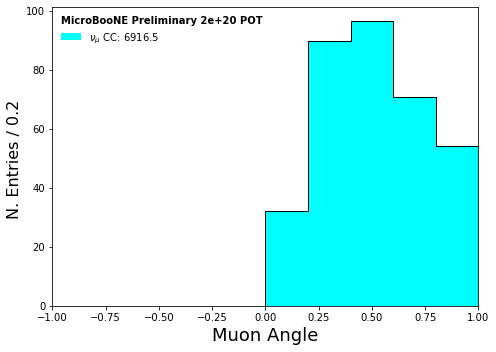

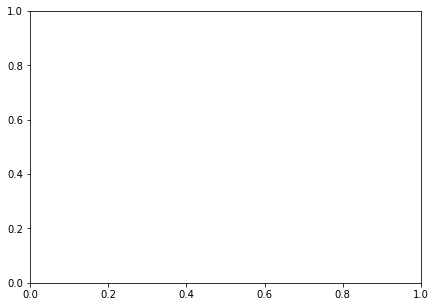

In [40]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = n_events

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    mcratio   = pot/2.33652e+21

    
    weights = { #full sample mc = 0.38
                "numu_mc": mcratio  * SPLIT * scaling,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #BDT


    #Now check on a variable

    #Remember to change the plotter keys between truth and mc

    #VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1, 1),"cos(Muon Angle)"
    VARIABLE, BINS, RANGE, XTIT = 'nu_Angle_Numi_Elec',10,(-1, 1),"Muon Angle"
    #VARIABLE, BINS, RANGE, XTIT = 'muon_pz',10,(-1000,1000),"Muon Pz"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        #query= "",
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]

    #ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
    #ax1.set_yscale("log")
    #fig.tight_layout()
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.


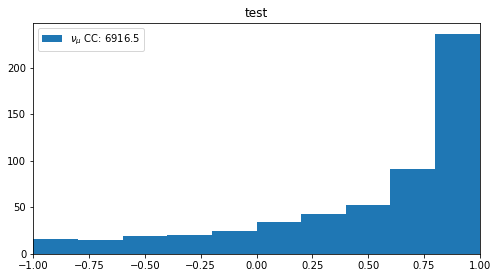

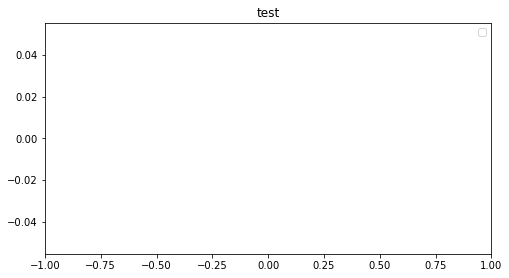

In [33]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    #nue_ax1.set_xlim([0, 5])   #trueE
    nue_ax1.set_xlim([-1, 1])   #angleElec

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()

In [34]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)

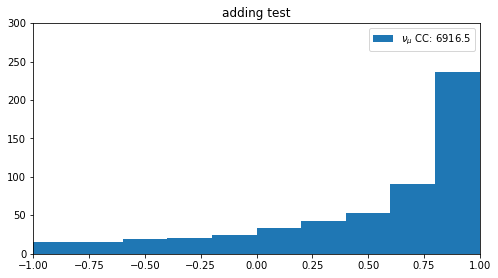

In [39]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$",
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}

labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])
#nue_ax1.set_xlim([0, 5])
#nue_ax1.set_ylim([0, 2500])
#angleElec
nue_ax1.set_xlim([-1, 1])
nue_ax1.set_ylim([0, 300])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [34]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

wanted_key = 4

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)


[]

SUMS
[]
[]

Wanted List:
[]



In [35]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

#presamp
#vars_tot_df.to_csv('numu_mc_varstot.csv')
#weights_tot_df.to_csv('numu_mc_weightstot.csv')

#full
#vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_trueE.csv')
#weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_trueE.csv')
#angleElec
vars_tot_df.to_csv('numu_mc_varstot_full_catsel_nopions_angleElec.csv')
weights_tot_df.to_csv('numu_mc_weightstot_full_catsel_nopions_angleElec.csv')

### Stat Errors

In [36]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20
    mcratio   = pot/2.33652e+21 

    
    weights = {
                "numu_mc"  : mcratio  * SPLIT * scaling
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    #VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  914729

22.868225
22
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_mc

err numu mc: 
[ 0.          0.          0.         23.35819601  0.          0.
  0.          0.          0.          0.        ]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [  0.       0.       0.     298.9086   0.       0.       0.       0.
   0.       0.    ]
Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2 
 


err numu mc: 
[7.32691217e-03 0.00000000e+00 0.00000000e+00 2.29259082e+01
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 1.46538243e-02]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [5.3888578e-02 0.0000000e+00 0.0000000e+00 2.9153360e+02 0.0000000e+00
 0.0000000e+00 0.0000000e+00 0.0000000e+00 0.0000000e+00 1.9931638e-01]
Returning
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_mc

err numu mc: 
[ 0.          0.          0.         23.45344586  0.          0.
  0.          0.          0.          0.        ]
detsys numu mc: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [  0.       0.       0.     305.3553   0.       0.   

In [37]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errors = ", total_errs)

numu_mc_stat_errs = total_errs

#########################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_mc_stat_errs_selected = total_sels

total errors =  [0.014653824344570656, 0.007326912172285328, 0.0, 543.2685568384402, 0.014653824344570656, 0.014653824344570656, 0.021980736516855982, 0.05861529737828263, 0.029307648689141312, 0.21248045299627447]
total selected =  [0.18203625455498695, 0.08074892312288284, 0.0, 6912.352935791016, 0.14260167255997658, 0.18588801473379135, 0.20356045570224524, 0.6469235233962536, 0.3228774070739746, 2.3551005743502174]


In [38]:
"""
np.savetxt("numu_mc_stat_errs_full_catsel_nopions_trueE.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_trueE.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')
"""
############################
#####angleElec#############
#############################

np.savetxt("numu_mc_stat_errs_full_catsel_nopions_angleElec.csv", 
           numu_mc_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_stat_errs_selected_full_catsel_nopions_angleElec.csv", 
           numu_mc_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')


## Sys errs - numu mc

In [18]:
#############################
##### weightsPPFX ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_ppfx = []
df_ppfx_vars = []
df_ppfx_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"

    n_cv_tot, n_tot, df_ppfx, df_ppfx_var, df_ppfx_spline  = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsPPFX",
        #category_query = " and category == 2",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5] # could this be the return issue?
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_ppfx.append(df_ppfx)
    df_ppfx_vars.append(df_ppfx_var)
    df_ppfx_splines.append(df_ppfx_spline)

n_events here =  914729

22.868225
22
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 103

Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 103

In [19]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_ppfx = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_ppfx.append(sum(masterlist[a]))


final_ncvs_numu_mc_ppfx = sum(n_cv_tots)


#------------------------
frames = []
for a in range(len(dfs_ppfx)):
    frames.append(dfs_ppfx[a][0])
    
total_ppfx_df = pd.concat(frames, ignore_index=True)
#print(total_ppfx_df)

#-----------------
frames2 = []
for b in range(len(df_ppfx_vars)):
    frames2.append(df_ppfx_vars[b][0])
    
    
total_ppfx_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_ppfx_df_vars)

#-----------------
frames3 = []
for c in range(len(df_ppfx_splines)):
    frames3.append(df_ppfx_splines[c][0])
    
    
total_ppfx_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_ppfx_df_splines)

In [20]:
np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_trueE.csv", 
           final_ns_numu_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_trueE.csv", 
           final_ncvs_numu_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_trueE.csv')
total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_trueE.csv')
total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_trueE.csv')

###############################
######angleElec##########
######################
"""
np.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleElec.csv", 
           final_ns_numu_mc_ppfx[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleElec.csv", 
           final_ncvs_numu_mc_ppfx,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_ppfx_df.to_csv('numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleElec.csv')
total_ppfx_df_vars.to_csv('numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleElec.csv')
total_ppfx_df_splines.to_csv('numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleElec.csv')
"""

'\nnp.savetxt("numu_mc_syserss_final_ns_ppfx_full_500_catsel_nopions_angleElec.csv", \n           final_ns_numu_mc_ppfx[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("numu_mc_syserss_final_ncvs_ppfx_full_500_catsel_nopions_angleElec.csv", \n           final_ncvs_numu_mc_ppfx,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_ppfx_df.to_csv(\'numu_mc_syserss_df_ppfx_full_500_catsel_nopions_angleElec.csv\')\ntotal_ppfx_df_vars.to_csv(\'numu_mc_syserss_df_ppfx_vars_full_500_catsel_nopions_angleElec.csv\')\ntotal_ppfx_df_splines.to_csv(\'numu_mc_syserss_df_ppfx_splines_full_500_catsel_nopions_angleElec.csv\')\n'

In [21]:
#############################
##### weightsgenie ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_genie = []
df_genie_vars = []
df_genie_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"

    n_cv_tot, n_tot, df_genie, df_genie_var, df_genie_spline = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsGenie",
        #category_query = " and category == 2",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_genie.append(df_genie)
    df_genie_vars.append(df_genie_var)
    df_genie_splines.append(df_genie_spline)

n_events here =  914729

22.868225
22
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 103

Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 103

In [22]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_genie = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_genie.append(sum(masterlist[a]))

final_ncvs_numu_mc_genie = sum(n_cv_tots)

##################################################

frames = []
for a in range(len(dfs_genie)):
    frames.append(dfs_genie[a][0])
    
    
total_genie_df = pd.concat(frames, ignore_index=True)
#print(total_genie_df)

#-----------------
frames2 = []
for b in range(len(df_genie_vars)):
    frames2.append(df_genie_vars[b][0])
    
    
total_genie_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_genie_df_vars)

#-----------------
frames3 = []
for c in range(len(df_genie_splines)):
    frames3.append(df_genie_splines[c][0])
    
    
total_genie_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_genie_df_splines)


In [23]:
np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_trueE.csv", 
           final_ns_numu_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_trueE.csv", 
           final_ncvs_numu_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_trueE.csv')
total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_trueE.csv')
total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_trueE.csv')

###########################
#####angleElec###########
##########################
"""
p.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleElec.csv", 
           final_ns_numu_mc_genie[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleElec.csv", 
           final_ncvs_numu_mc_genie,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_genie_df.to_csv('numu_mc_syserss_df_genie_full_500_catsel_nopions_angleElec.csv')
total_genie_df_vars.to_csv('numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleElec.csv')
total_genie_df_splines.to_csv('numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleElec.csv')
"""

'\np.savetxt("numu_mc_syserss_final_ns_genie_full_500_catsel_nopions_angleElec.csv", \n           final_ns_numu_mc_genie[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("numu_mc_syserss_final_ncvs_genie_full_500_catsel_nopions_angleElec.csv", \n           final_ncvs_numu_mc_genie,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_genie_df.to_csv(\'numu_mc_syserss_df_genie_full_500_catsel_nopions_angleElec.csv\')\ntotal_genie_df_vars.to_csv(\'numu_mc_syserss_df_genie_vars_full_500_catsel_nopions_angleElec.csv\')\ntotal_genie_df_splines.to_csv(\'numu_mc_syserss_df_genie_splines_full_500_catsel_nopions_angleElec.csv\')\n'

In [24]:
#############################
##### weightsReint ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_reint = []
df_reint_vars = []
df_reint_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"

    n_cv_tot, n_tot, df_reint, df_reint_var, df_reint_spline = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        typeerr = "standard",
        weight = "weightsReint",
        #category_query = " and category == 2",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5] # could this be the return issue?
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_reint.append(df_reint)
    df_reint_vars.append(df_reint_var)
    df_reint_splines.append(df_reint_spline)

n_events here =  914729

22.868225
22
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 103

Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

standard sys err
Universes 500
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 103

In [25]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)


masterlist.pop(0)
final_ns_numu_mc_reint = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_reint.append(sum(masterlist[a]))

final_ncvs_numu_mc_reint = sum(n_cv_tots)

###################################################

frames = []
for a in range(len(dfs_reint)):
    frames.append(dfs_reint[a][0])
    
    
total_reint_df = pd.concat(frames, ignore_index=True)
#print(total_reint_df)

#-----------------
frames2 = []
for b in range(len(df_reint_vars)):
    frames2.append(df_reint_vars[b][0])
    
    
total_reint_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_reint_df_vars)

#-----------------
frames3 = []
for c in range(len(df_reint_splines)):
    frames3.append(df_reint_splines[c][0])
    
    
total_reint_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_reint_df_splines)

In [26]:
np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_trueE.csv", 
           final_ns_numu_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_trueE.csv", 
           final_ncvs_numu_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_trueE.csv')
total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_trueE.csv')
total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_trueE.csv')

#############################
#####angleElec##########
#######################
"""
np.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleElec.csv", 
           final_ns_numu_mc_reint[0],
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleElec.csv", 
           final_ncvs_numu_mc_reint,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_reint_df.to_csv('numu_mc_syserss_df_reint_full_500_catsel_nopions_angleElec.csv')
total_reint_df_vars.to_csv('numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleElec.csv')
total_reint_df_splines.to_csv('numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleElec.csv')
"""

'\nnp.savetxt("numu_mc_syserss_final_ns_reint_full_500_catsel_nopions_angleElec.csv", \n           final_ns_numu_mc_reint[0],\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("numu_mc_syserss_final_ncvs_reint_full_500_catsel_nopions_angleElec.csv", \n           final_ncvs_numu_mc_reint,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_reint_df.to_csv(\'numu_mc_syserss_df_reint_full_500_catsel_nopions_angleElec.csv\')\ntotal_reint_df_vars.to_csv(\'numu_mc_syserss_df_reint_vars_full_500_catsel_nopions_angleElec.csv\')\ntotal_reint_df_splines.to_csv(\'numu_mc_syserss_df_reint_splines_full_500_catsel_nopions_angleElec.csv\')\n'

In [27]:
#############################
##### weightsNuMIGeo ###########
#############################

import syserr_batch_plotter_alex
import importlib
importlib.reload(syserr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_mc.shape[0]
print("n_events here = ", n_events)
batch_size = 40000

n_cv_tots = []
n_tots = []
dfs_geo = []
df_geo_vars = []
df_geo_splines = []

print(n_events/batch_size)
print(int(n_events/batch_size)+1)

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_mc.iloc[start:end]

    samples = {
        "numu_mc": sample_set 
    }


    scaling = 1
    pot =  2e+20 
    mcratio   = pot/2.33652e+21
    
    weights = {
               "numu_mc"  : mcratio  * SPLIT * scaling 
    }


    my_plotter = syserr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'nu_e',10,(0.0, 5.0),"True Energy [GeV]"
    #VARIABLE, BINS, RANGE, XTIT = 'cosNu_Angle_Numi_Elec',10,(-1.0, 1.0),"cos(Electron Angle)"

    n_cv_tot, n_tot, df_geo, df_geo_var, df_geo_spline = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_mc",
        typeerr = "NuMIGeo",
        weight = "weightsGenie",
        #category_query = " and category == 2",
        category_query = " ",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:5]
    
    
    n_cv_tots.append(n_cv_tot)
    n_tots.append(n_tot)
    dfs_geo.append(df_geo)
    df_geo_vars.append(df_geo_var)
    df_geo_splines.append(df_geo_spline)

n_events here =  914729
22.868225
23
{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 1

Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55  and nproton > 0 and npion == 0 and nu_e > 0.04 and nu_e < 5) and category == 2& nu_e <= 5 & nu_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

NuMI Geo sys err
Number of variations Universes 10
Returning
--------------------------

{'numu_mc': 0.08559738414394057}
(nu_pdg == 

In [28]:
masterlist = []
templist = []
for i in range((len(n_tots[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(n_tots)):
        templist.append(n_tots[j][i])
masterlist.append(templist)

#need to sum each part of the masterlist into one pair of arrays now
masterlist.pop(0)
final_ns_numu_mc_geo = []

for a in range(len(masterlist)):
    #print(sum(masterlist[a]))
    final_ns_numu_mc_geo.append(sum(masterlist[a]))

final_ncvs_numu_mc_geo = sum(n_cv_tots)
    
for x in range(len(final_ns_numu_mc_geo)):
    final_ns_numu_mc_geo[x] = np.concatenate((final_ns_numu_mc_geo[x][0], final_ns_numu_mc_geo[x][1]))
    
#############################################################
frames = []
for a in range(len(dfs_geo)):
    frames.append(dfs_geo[a][0])
    
    
total_geo_df = pd.concat(frames, ignore_index=True)
#print(total_geo_df)

#-----------------
frames2 = []
for b in range(len(df_geo_vars)):
    frames2.append(df_geo_vars[b][0])
    
    
total_geo_df_vars = pd.concat(frames2, ignore_index=False)
#print(total_geo_df_vars)

#-----------------
frames3 = []
for c in range(len(df_geo_splines)):
    frames3.append(df_geo_splines[c][0])
    
    
total_geo_df_splines = pd.concat(frames3, ignore_index=False)
#print(total_geo_df_splines)

In [29]:
np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_trueE.csv", 
           final_ns_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_trueE.csv", 
           final_ncvs_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_trueE.csv')
total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_trueE.csv')
total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_trueE.csv')

########################
####angleElec##########
#######################

"""
np.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleElec.csv", 
           final_ns_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleElec.csv", 
           final_ncvs_numu_mc_geo,
           delimiter =", ", 
           fmt ='% s')

###########################################

total_geo_df.to_csv('numu_mc_syserss_df_geo_full_catsel_nopions_angleElec.csv')
total_geo_df_vars.to_csv('numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleElec.csv')
total_geo_df_splines.to_csv('numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleElec.csv')
"""

'\nnp.savetxt("numu_mc_syserss_final_ns_geo_full_catsel_nopions_angleElec.csv", \n           final_ns_numu_mc_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\nnp.savetxt("numu_mc_syserss_final_ncvs_geo_full_catsel_nopions_angleElec.csv", \n           final_ncvs_numu_mc_geo,\n           delimiter =", ", \n           fmt =\'% s\')\n\n###########################################\n\ntotal_geo_df.to_csv(\'numu_mc_syserss_df_geo_full_catsel_nopions_angleElec.csv\')\ntotal_geo_df_vars.to_csv(\'numu_mc_syserss_df_geo_vars_full_catsel_nopions_angleElec.csv\')\ntotal_geo_df_splines.to_csv(\'numu_mc_syserss_df_geo_splines_full_catsel_nopions_angleElec.csv\')\n'

## Numu_Dirt

In [2]:
tree = "NeutrinoSelectionFilter"

DRT  = '/prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot'  +ls.APPEND

numu_dirt = uproot.open(ls.ntuple_path+DRT+".root")[ls.fold][tree]


uproot_v = [numu_dirt] 


numu_variables = [
        "nu_pdg", "slpdg", "backtracked_pdg", #"trk_score_v", 
        "category", "ccnc",
        "run","sub","evt",
        "CosmicIP","CosmicDirAll3D","CosmicIPAll3D",
        "flash_pe",
        "trk_llr_pid_score_v", # trk-PID score
        "_opfilter_pe_beam", "_opfilter_pe_veto", # did the event pass the common optical filter (for MC only)
        "reco_nu_vtx_sce_x","reco_nu_vtx_sce_y","reco_nu_vtx_sce_z",
        "nproton",
        #"nu_e", 
        "reco_e",
        "nproton", "mc_pdg", "slnunhits", "slnhits", "true_e_visible",
        "npi0","npion","pion_e","muon_e","pi0truth_elec_etot",
        "pi0_e", "evnunhits", "nslice", "interaction",
        "slclustfrac", "reco_nu_vtx_x", "reco_nu_vtx_y", "reco_nu_vtx_z",
        "topological_score",
        "isVtxInFiducial",
        "theta", # angle between incoming and outgoing leptons in radians
        "true_nu_vtx_z", "true_nu_vtx_y", "true_nu_vtx_x", "nu_e"
    ]

numu_varMC = ["true_pt","true_pt_visible","true_p","true_p_visible","true_nu_vtx_t","true_nu_vtx_x","true_nu_vtx_y","true_nu_vtx_z","true_nu_vtx_sce_x","true_nu_vtx_sce_y","true_nu_vtx_sce_z\
","true_nu_px","true_nu_py","true_nu_pz"]

#make the list unique
numu_variables = list(set(numu_variables))
print(numu_variables)


    
WEIGHTS     = ["weightSpline","weightTune","weightSplineTimesTune","ppfx_cv"]
SYSTEMATICS = ['weightsFlux','weightsGenie','weightsReint'] 
PPFX        = ['weightsPPFX'] 



WEIGHTSLEE = ["weightSpline","weightTune","weightSplineTimesTune", "leeweight"]#, "weightsGenie", "weightsFlux", "weightsReint"]
MCFVARS    = ["mcf_nu_e","mcf_lep_e","mcf_actvol","mcf_nmm","mcf_nmp","mcf_nem","mcf_nep","mcf_np0","mcf_npp",
              "mcf_npm","mcf_mcshr_elec_etot","mcf_pass_ccpi0","mcf_pass_ncpi0",
              "mcf_pass_ccnopi","mcf_pass_ncnopi","mcf_pass_cccpi","mcf_pass_nccpi"]

['reco_nu_vtx_sce_y', 'category', 'reco_nu_vtx_y', 'slnhits', 'isVtxInFiducial', 'nu_e', 'npion', 'true_nu_vtx_y', 'ccnc', 'reco_e', 'nslice', 'pi0_e', 'topological_score', 'true_nu_vtx_x', 'true_nu_vtx_z', 'nu_pdg', 'backtracked_pdg', '_opfilter_pe_beam', 'npi0', 'run', 'pi0truth_elec_etot', 'true_e_visible', 'reco_nu_vtx_sce_x', 'evnunhits', 'CosmicIPAll3D', '_opfilter_pe_veto', 'reco_nu_vtx_sce_z', 'slnunhits', 'slpdg', 'mc_pdg', 'sub', 'slclustfrac', 'pion_e', 'interaction', 'CosmicIP', 'theta', 'evt', 'flash_pe', 'nproton', 'trk_llr_pid_score_v', 'CosmicDirAll3D', 'reco_nu_vtx_z', 'reco_nu_vtx_x', 'muon_e']


In [3]:
import pandas as pandas

dirt_var = numu_variables + numu_varMC + WEIGHTS + SYSTEMATICS


# This needs modifications (add variables from above)
uproot_v = [numu_dirt] 
var_v    = [dirt_var] 

for ii, CV in enumerate(uproot_v):
    CVDF  = CV.pandas.df(var_v[ii], flatten=False)
    load_data_run123.process_uproot_numu(CV,CVDF)
    if ii == 0:
        numu_dirt =  CVDF

/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1557: RuntimeWarning: overflow encountered in reduceat
  out = ufunc.reduceat(content, awkward.util.windows_safe(nonterminal))[:len(out)]
/home/alex/miniconda3/envs/vintageXgboostVintageUprootEnv/lib/python3.8/site-packages/awkward/array/jagged.py:1043: RuntimeWarning: overflow encountered in power
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [4]:
df_v = [numu_dirt]
for i,df in enumerate(df_v):
    df[ 'currentweightsafe' ] = df['weightSplineTimesTune']
    df[ 'currentweight' ] = df['weightSplineTimesTune']

In [5]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df.loc[ df['weightTune'] <= 0, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] == np.inf, 'weightTune' ] = 1.
    df.loc[ df['weightTune'] > 100, 'weightTune' ] = 1.
    df.loc[ np.isnan(df['weightTune']) == True, 'weightTune' ] = 1.    
    
    df.loc[ df['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df.loc[ df['weightSplineTimesTune'] > 100, 'weightSplineTimesTune' ] = 1.
    df.loc[ np.isnan(df['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1. 
    df[ 'weightSplineTimesTuneTimesPPFX' ] = df[ 'weightSplineTimesTune' ]*df['ppfx_cv']
    
    df.loc[ df['weightSpline'] <= 0, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] == np.inf, 'weightSpline' ] = 1.
    df.loc[ df['weightSpline'] > 100, 'weightSpline' ] = 1.
    df.loc[ np.isnan(df['weightSpline']) == True, 'weightSpline' ] = 1. 
    df[ 'weightSplineTimesPPFX' ]  = df[ 'weightSpline' ]*df['ppfx_cv']
    
    for ievt in range(df.shape[0]):
        reweightCondition = ((df['weightsGenie'].iloc[ievt] > 3000) | (df['weightsGenie'].iloc[ievt] < 0)  | 
                             (df['weightsGenie'].iloc[ievt] == np.inf))
        df['weightsGenie'].iloc[ievt][ reweightCondition ] = 1.

In [6]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'currentweight' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweightsafe2' ] = df['weightSplineTimesTuneTimesPPFX']
    df[ 'currentweight2' ] = df['weightSplineTimesTuneTimesPPFX']

In [7]:
df_v = [numu_dirt]
#removeGenieTune = False
for i,df in enumerate(df_v):
    df[ 'noW' ] = 1

In [8]:
df_v = [numu_dirt]
for i,df in enumerate(df_v):  
    df["bnbdata"] = np.zeros_like(df["isVtxInFiducial"])
    df["extdata"] = np.zeros_like(df["isVtxInFiducial"])

In [9]:
def energyToPxyz(energy, theta, phi, mask, mass = 0.93827208816):
    if all(~mask):
        return (0.,0.,0.)
    energy = energy.copy()[mask]
    theta  = theta.copy()[mask]
    phi    = phi.copy()[mask]
    
    p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)
    pz = p*np.cos(theta)
    px = p*np.sin(theta)*np.cos(phi)
    py = p*np.sin(theta)*np.sin(phi)
    return( px.sum(), py.sum(), pz.sum())



for i,df in enumerate(df_v):
    up = uproot_v[i]
    trk_theta_proton_v  = up.array('trk_theta_v')
    trk_phi_proton_v    = up.array('trk_phi_v')
    trk_energy_proton_v = up.array('trk_energy_proton_v')
    ############ muon part
    mu_px_v            = up.array('shr_px')
    mu_py_v            = up.array('shr_py')
    mu_pz_v            = up.array('shr_pz')
    pt_v                = up.array('pt')
    trk_score_v         = up.array('trk_score_v')    
    trk_llr_pid_v       = up.array('trk_llr_pid_score_v')
    
    
    #shr_mask = (trk_score_v<0.5)
    trk_mask      = (trk_score_v>0.5)
    proton_mask_v = (trk_score_v>0.5)&(trk_llr_pid_v < 0.)
    sillyCount = 0
    listPx,listPy,listPz = [],[],[]
    
    for mask, theta_t, phi_t, energy_t,proton_mask_v_t,sx,sy,sz,pttt  in zip(proton_mask_v, trk_theta_proton_v,trk_phi_proton_v, trk_energy_proton_v,proton_mask_v, mu_px_v,mu_py_v,mu_pz_v,pt_v):
        tempMom = energyToPxyz(energy_t,theta_t,phi_t,proton_mask_v_t) 
        nu_reco_px = tempMom[0] + sx 
        nu_reco_py = tempMom[1] + sy  
        nu_reco_pz = tempMom[2] + sz  
        listPx.append(nu_reco_px)
        listPy.append(nu_reco_py)
        listPz.append(nu_reco_pz)


/tmp/ipykernel_3506/3728966960.py:8: RuntimeWarning: overflow encountered in multiply
  p  = np.sqrt((energy+mass)*(energy+mass) - mass*mass)


In [10]:
numu_dirt["is_signal"] = numu_dirt["category"] == 11

In [11]:
from scipy.spatial.transform import Rotation as R
from numpy import arccos, array
from numpy.linalg import norm

# Note: returns angle in radians
def theta(v, w): return arccos(v.dot(w)/(norm(v)*norm(w)))* 180 / 3.1415926

def GetNuMIAngle( px,  py,  pz):
    r = R.from_matrix([[0.92103853804025681562   , 0.022713504803924120662, 0.38880857519374290021  ],
                       [4.6254001262154668408e-05, 0.99829162468141474651 , -0.058427989452906302359],
                       [-0.38947144863934973769  , 0.053832413938664107345, 0.91946400794392302291  ]])  
    r = r.inv()
    beamCoords = r.apply([px,  py,  pz])
    beamDir    = [0,0,1]
    #print(theta(beamCoords,beamDir))
    return theta(beamCoords,beamDir)

def GetNuMIAnglePol( phiBNB,  thetaBNB):
    px = math.sin(thetaBNB)*math.cos(phiBNB)
    py = math.sin(thetaBNB)*math.sin(phiBNB)
    pz = math.cos(thetaBNB)
    return GetNuMIAngle( px,  py,  pz)

In [12]:
numu_dirt = numu_dirt.query('nu_e > 0.')

import NuMIGeoWeights
import importlib
importlib.reload(NuMIGeoWeights)
numiBeamlineGeoWeights = NuMIGeoWeights.NuMIGeoWeights()

# Calculate the true neutrino direction off of the NuMI beam, needed for plotting. Seem to be from MC
dfmc_v = [numu_dirt]
for i,df in enumerate(dfmc_v):
    df['numi_nu_true_Angle'] = df.apply( lambda x: GetNuMIAngle(x['true_nu_px'],x['true_nu_py'],x['true_nu_pz']) , axis=1)
    df['weightsNuMIGeo']     = df.apply( lambda x: numiBeamlineGeoWeights.calculateGeoWeight(x['nu_pdg'],x['nu_e'],x['numi_nu_true_Angle']) , axis=1)
 

In [13]:
NUMU_SEL_QUERY = 'nslice == 1'
NUMU_SEL_QUERY += ' and ( (_opfilter_pe_beam > 0 and _opfilter_pe_veto < 20) or bnbdata == 1 or extdata == 1)'
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_x > -1.55 and reco_nu_vtx_sce_x < 254.8 '
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_y > -116.5 and reco_nu_vtx_sce_y < 116.5 '
NUMU_SEL_QUERY += ' and reco_nu_vtx_sce_z > 0 and reco_nu_vtx_sce_z < 1036.8 '
NUMU_SEL_QUERY += ' and n_muons_tot > 0'
NUMU_SEL_QUERY += ' and n_protons_tot > 0 '

In [14]:
truthsel_nue  = "(nu_pdg == 12 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0) and nu_e > 0.04 and nu_e < 5"

truthsel_numu  = "(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x < \
 254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)"

n_events here =  569506

5.69506
5
{'numu_dirt': 0.08442202570650682}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  numu_dirt
Had to return early.
{'numu_dirt': 0.08442202570650682}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False
current sample is:  numu_dirt
Had to return early.
{'numu_dirt': 0.08442202570650682}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_

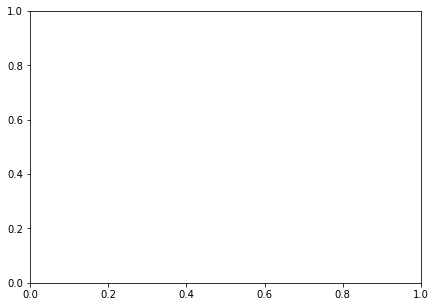

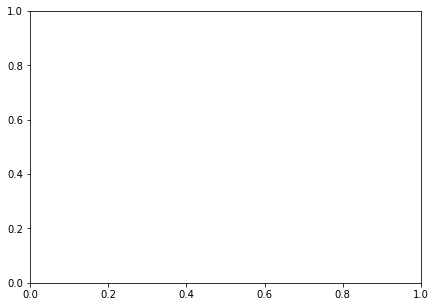

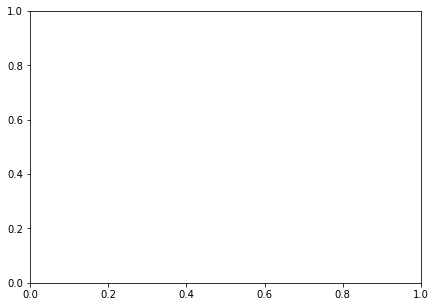

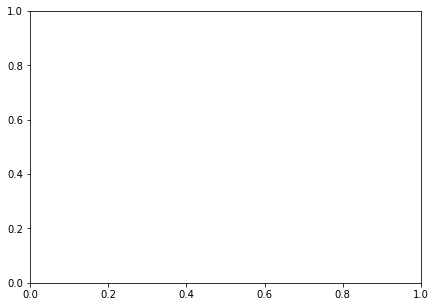

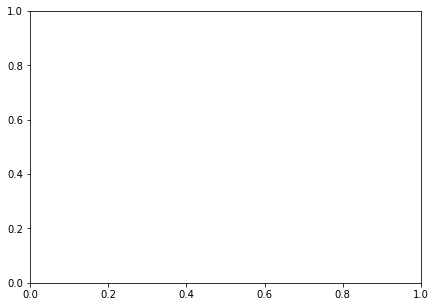

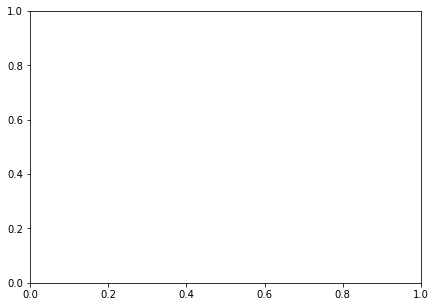

In [15]:
import batch_plotter_alex
import importlib
importlib.reload(batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 100000

varss = []
weightss = []
labss = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    # This is the data POT we normalize to (comes from the data Ntuples)
    pot =  2e+20 #partial file: 8.885e+19
    dirtratio = pot/1.42143e+21
    scalingDRT = 0.60

    # NUE
    weights = { #full sample mc = 0.38
                "numu_dirt": dirtratio* SPLIT * scalingDRT,
    }


    my_plotter = batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)

    #BDT


    #Now check on a variable

    #Remember to change the plotter keys between truth and mc

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    var, weight, label = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3]

    #ax1.set_title('NuMI Run 1, FHC, Nue - Reconstructed Energies',loc='left')
    #ax1.set_yscale("log")
    #fig.tight_layout()
    
    varss.append(var)
    weightss.append(weight)
    labss.append(label)

No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.
No handles with labels found to put in legend.


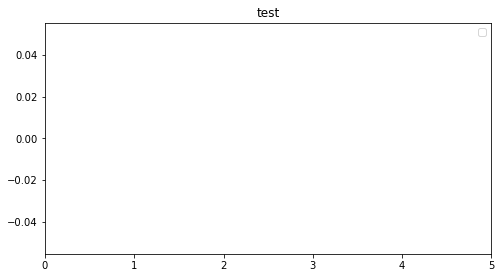

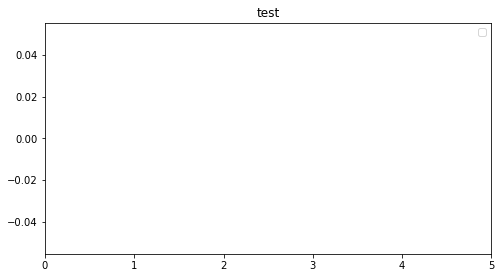

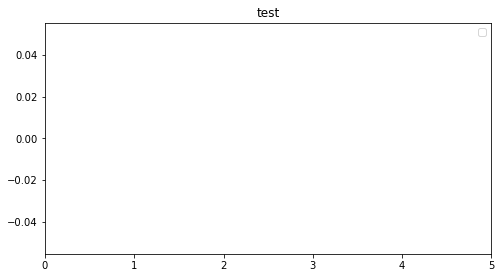

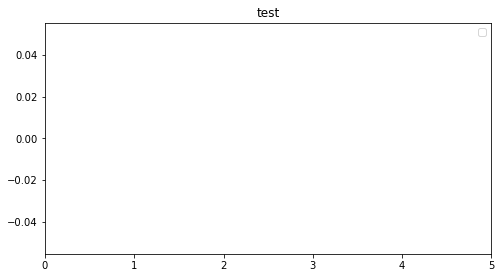

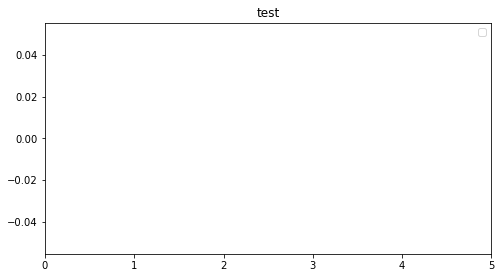

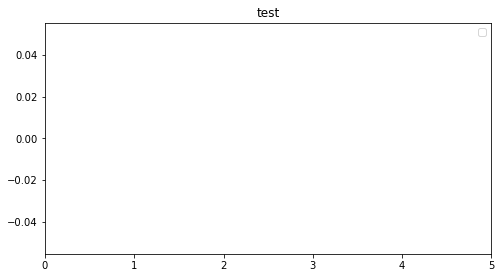

In [16]:
from matplotlib import gridspec

for i in range(int(n_events/batch_size)+1):
    nue_fig = plt.figure(figsize=(8, 7))
    nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
    nue_ax1 = plt.subplot(nue_gs[0])
    nue_ax1.set_xlim([0, 5])

    nue_stacked = nue_ax1.hist(
                varss[i].values(),
                weights=list(weightss[i].values()),
                stacked=True,
                label=labss[i],
                bins=BINS,
                range=RANGE)
    
    plt.title("test")
    plt.legend()


In [17]:
def mergeDictionary(dict_1, dict_2):
    dict_3 = {**dict_1, **dict_2}
    for key, value in dict_3.items():
        if key in dict_1 and key in dict_2:
                dict_3[key] = value + dict_1[key]
    return dict_3

def combine_dicts(mydict):
    while len(mydict) > 1:
        i = 0
        dict_3 = mergeDictionary(mydict[i], mydict[i+1]) 
        mydict.pop(0)
        mydict[0] = dict_3
    return mydict
    
varss_tot = combine_dicts(varss)
weightss_tot = combine_dicts(weightss)



No handles with labels found to put in legend.


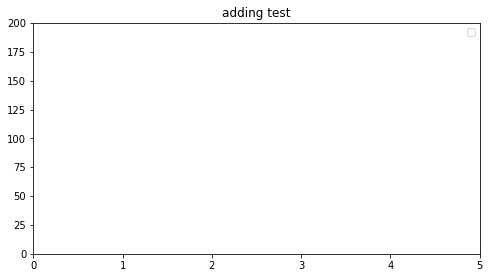

In [18]:
category_labels = {
    1: r"$\nu_e$ Other",
    11110: r"$\nu_e$",
    11111: r"$\bar\nu_e$",
    10: r"$\nu_e$ CC0$\pi$0p",
    9: r"$\bar\nu_e$ CC0$\pi$0p",
    12: r"$\bar\nu_e$ CC0$\pi$Np",
    11: r"$\nu_e$ CC0$\pi$Np",
    11357: r"$\nu_e$ CC $\pi^{0}$",
    111: r"MiniBooNE LEE",
    2: r"$\nu_{\mu}$ CC",
    21: r"$\nu_{\mu}$ CC $\pi^{0}$",
    22: r"$\nu_{\mu}$ CC 0p$^+$",
    23: r"$\nu_{\mu}$ CC 1p$^+$",
    24: r"$\nu_{\mu}$ CC 2p$^+$",
    25: r"$\nu_{\mu}$ CC Np$^+$",
    3: r"$\nu$ NC",
    31: r"$\nu$ NC $\pi^{0}$",
    4: r"Cosmic",
    5: r"Out. fid. vol.",
    # eta categories start with 80XX
    801: r"$\eta \rightarrow$ other",
    802: r"$\nu_{\mu} \eta \rightarrow \gamma\gamma$",
    803: r'1 $\pi^0$',
    804: r'2 $\pi^0$',
    805: r'$\nu$ other',
    806: r'out of FV',
    6: r"other",
    0: r"No slice"
}


labels = [
            "%s: %.1f" % (category_labels[c], sum(weightss_tot[0][c])) \
            if sum(weightss_tot[0][c]) else ""
            for c in varss[0].keys()
        ]


nue_fig = plt.figure(figsize=(8, 7))
nue_gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1])
nue_ax1 = plt.subplot(nue_gs[0])
nue_ax1.set_xlim([0, 5])
nue_ax1.set_ylim([0, 200])

nue_stacked = nue_ax1.hist(
            varss_tot[0].values(),
            weights=list(weightss_tot[0].values()),
            stacked=True,
            label=labels,
            bins=BINS,
            range=RANGE)

plt.title("adding test")
plt.legend()

In [19]:
import importlib
import Plotter_Functions_Alex
importlib.reload(Plotter_Functions_Alex)
from Plotter_Functions_Alex import getWantedLists
importlib.reload(getWantedLists)

#print(nue_stacked)

wanted_key = 1

nue_wanted_list = Plotter_Functions_Alex.getWantedLists.getWantedLists(wanted_key, nue_stacked)

print(nue_wanted_list)

[]

SUMS
[]
[]

Wanted List:
[]

[]


In [20]:
vars_tot_df = pd.DataFrame.from_dict(varss_tot)
weights_tot_df = pd.DataFrame.from_dict(weightss_tot)

vars_tot_df.to_csv('numu_dirt_varstot.csv')
weights_tot_df.to_csv('numu_dirt_weightstot.csv')

### Stat Errors

In [21]:
import staterr_batch_plotter_alex
import importlib
importlib.reload(staterr_batch_plotter_alex)
scaling = 1

SPLIT = 1.0

n_events = numu_dirt.shape[0]
print("n_events here = ", n_events)
print("")
batch_size = 100000

errs = []
detsyss = []
sels = []

print(n_events/batch_size)
print(int(n_events/batch_size))

for i in range(int(n_events/batch_size)+1):
    start = i*batch_size
    if (start + batch_size) < n_events:
        end = start + batch_size
    else:
        end = n_events
    sample_set = numu_dirt.iloc[start:end]

    samples = {
        "numu_dirt": sample_set 
    }


    scaling = 1
    pot =  2e+20
    dirtratio = pot/1.42143e+21
    scalingDRTnumu = 0.60

    
    weights = {
                "numu_dirt": dirtratio* SPLIT * scalingDRTnumu
    }


    my_plotter = staterr_batch_plotter_alex.Plotter(samples, weights, pot=pot)
    print(weights)
    
    

    VARIABLE, BINS, RANGE, XTIT = 'reco_e',10,(0.0, 5.0),"Reconstructed Energy [GeV]"

    err, detsys, selected = my_plotter.plot_variable(
        VARIABLE,   
        #nue_query= NUE_SEL_QUERY,
        #numu_query= NUMU_SEL_QUERY,
        query= truthsel_numu,
        currentsample = "numu_dirt",
        kind="event_category",
        draw_sys  = True, 
        draw_geoSys = True, 
        draw_data = True,
        ratio=False,
        genieweight = "weightSplineTimesTuneTimesPPFX",  
        stacksort=3,
        title=XTIT,
        bins=BINS,
        range=RANGE
    )[0:3] # could this be the return issue?
    
    
    errs.append(err)
    detsyss.append(detsys)
    sels.append(selected)

n_events here =  569506

5.69506
5
{'numu_dirt': 0.08442202570650682}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_dirt

err numu dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys numu dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]

selected  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Returning
{'numu_dirt': 0.08442202570650682}
(nu_pdg == 14 and ccnc == 0 and true_nu_vtx_z < 1036.8 and true_nu_vtx_z > 0 and true_nu_vtx_y < 116.5 and true_nu_vtx_y > -116.5 and true_nu_vtx_x <  254.8 and true_nu_vtx_x > -1.55 and nproton > 0 and nu_e > 0.04 and nu_e < 5)& reco_e <= 5 & reco_e >= 0 
 ~(abs(nu_pdg) == 12 & ccnc == 0) 
 None 
 False

current sample is:  numu_dirt

err numu dirt: 
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
detsys numu dirt: 


In [22]:
#print(errs)
#print(sels)

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlist = []
templist = []
for i in range((len(errs[0]))):
    masterlist.append(templist)
    templist = []
    for j in range(len(errs)):
        templist.append(errs[j][i])
masterlist.append(templist)
    
masterlist.pop(0)


#deal with adding the errors in each bin
total_errs = []
holdlist = []
for f in masterlist:
    total_errs.append(sum(holdlist))
    #print("------------------------------")
    holdlist = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlist.append(g)
total_errs.append(sum(holdlist))

total_errs.pop(0)
print("total errors = ", total_errs)

numu_dirt_stat_errs = total_errs


######################################################

#arrange the lists such that all the errors from bin 1 are in one list, bin 2 in another list, etc...
masterlistsels = []
templistsels = []
for i in range((len(sels[0]))):
    masterlistsels.append(templistsels)
    templistsels = []
    for j in range(len(sels)):
        templistsels.append(sels[j][i])
masterlistsels.append(templistsels)
    
masterlistsels.pop(0)


#deal with adding the errors in each bin
total_sels = []
holdlistsels = []
for f in masterlistsels:
    total_sels.append(sum(holdlistsels))
    #print("------------------------------")
    holdlistsels = []
    for g in f:
        #just add them as they differnt parts of the same total number. This then matches previous when doing total
        holdlistsels.append(g)
total_sels.append(sum(holdlistsels))

total_sels.pop(0)
print("total selected = ", total_sels)

numu_dirt_stat_errs_selected = total_sels

total errors =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
total selected =  [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [23]:
np.savetxt("numu_dirt_stat_errs.csv", 
           numu_dirt_stat_errs,
           delimiter =", ", 
           fmt ='% s')

np.savetxt("numu_dirt_stat_errs_selected.csv", 
           numu_dirt_stat_errs_selected,
           delimiter =", ", 
           fmt ='% s')

## Sys_errs

Dirt does not get sys errors calculated.